In [1]:
import numpy as np
import pandas as pd
import plotly.express
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
%matplotlib inline

import scipy

from sklearn.linear_model import LinearRegression

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

rc('font',**{'family':'sans-serif'})
rc('figure', **{'dpi': 300})

# Part 1

## Task 1 & 2

В этой задаче нужно оценить вероятность того, что подсудимый убийца, при словии, что у него редкая группа крови. Пусть k = 1 если перед нами убийца, и 0 - в противном случае. Также, пусть у нас есть свидетельства $e_1, e_2, ... e_k$. Тогда нам нужно оценить вероятность 
$P(k = 1 | e_1, ... e_k)$. Прокурор оценивал вероятность $e_1$ - шанс, что у случайно выбранного жителя города окажется редкая группа крови. Адвокат оценивал вероятность $P(k = 1 | e_1)$ - то есть шанс случайно выбранного жителя с редкой группой крови оказаться убийцей. Стоит заметить, что даже одно такое свидетельство сильно сократило круг подозреваемых - в 100 раз.

## Task 3

In [4]:
p_d = 0.01 #Desease prob
p_fp = 0.05 #False positive prob
p_fn = 0.05 #False negative prob

In [5]:
def calc_prob(p_d, p_fp, p_fn):
    return (1 - p_fn) * p_d / ((1 - p_fn) * p_d + p_fp * (1 - p_d))

In [6]:
calc_prob(p_d, p_fp, p_fn)

0.16101694915254236

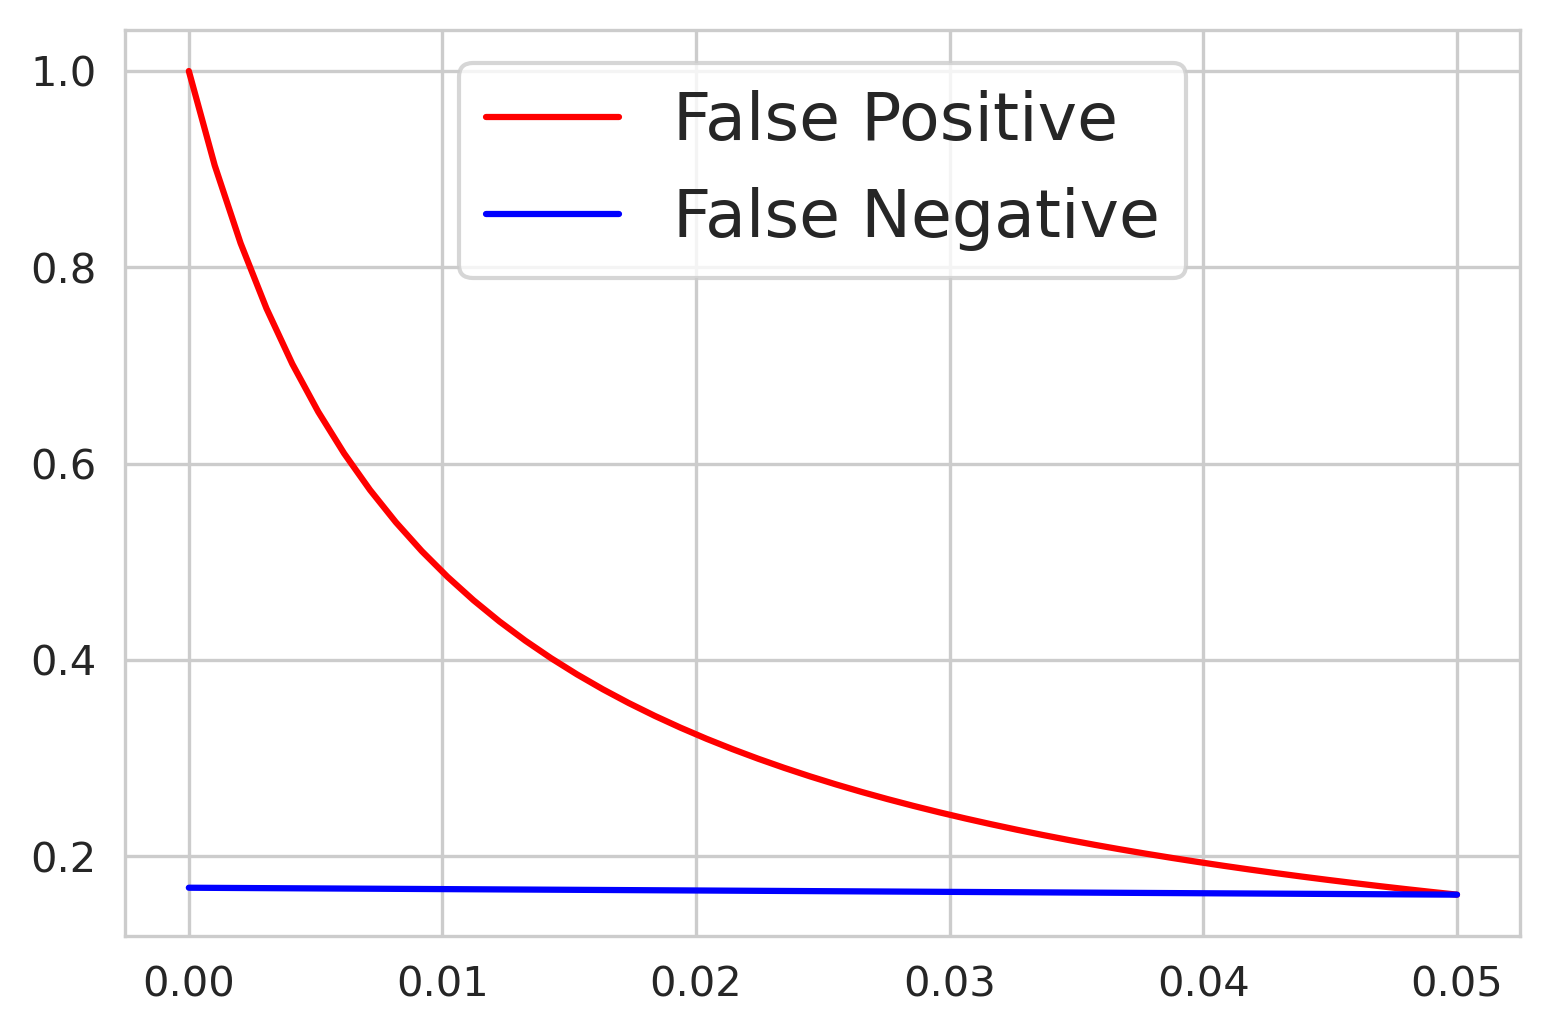

In [7]:
failure_rate = np.linspace(0, 0.05)
plt.plot(failure_rate, calc_prob(p_d, failure_rate, p_fn), color='red', label='False Positive')
plt.plot(failure_rate, calc_prob(p_d, p_fp, failure_rate), color='blue', label='False Negative')
plt.legend(loc="upper center", fontsize=legend_fontsize)
plt.show()

Результат на графике. Уменьшение доли False Negative не сильно влияет на результат. Поэтому нужно бороться за снижение доли False Positive. Интуитивно, снижение доли False Negative увеличит количество обнаруженных случаев только в рамках 5%  от 1% погрешности, в то время как снижение доли False Positive влияет на 5% случаев от 99%.

# Part II

## 1. Load data

In [8]:
RUS_START_DATE = datetime(2020, 3, 2)
RUS_END_DATE = RUS_START_DATE + timedelta(50)

In [9]:
data = pd.read_csv('owid-covid-data.csv', parse_dates=['date'])
data.head()

iso_code continent     location       date  total_cases  new_cases  \
0      AFG      Asia  Afghanistan 2020-02-24          1.0        1.0   
1      AFG      Asia  Afghanistan 2020-02-25          1.0        0.0   
2      AFG      Asia  Afghanistan 2020-02-26          1.0        0.0   
3      AFG      Asia  Afghanistan 2020-02-27          1.0        0.0   
4      AFG      Asia  Afghanistan 2020-02-28          1.0        0.0   

   new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  ...  \
0                 NaN           NaN         NaN                  NaN  ...   
1                 NaN           NaN         NaN                  NaN  ...   
2                 NaN           NaN         NaN                  NaN  ...   
3                 NaN           NaN         NaN                  NaN  ...   
4                 NaN           NaN         NaN                  NaN  ...   

   gdp_per_capita  extreme_poverty  cardiovasc_death_rate  \
0        1803.987              NaN                597.029   
1        1803.987              NaN                597.029   
2        1803.987              NaN                597.029   
3        1803.987              NaN                597.029   
4        1803.987              NaN                597.029   

   diabetes_prevalence  female_smokers  male_smokers  handwashing_facilities  \
0                 9.59             NaN           NaN                  37.746   
1                 9.59             NaN           NaN                  37.746   
2                 9.59             NaN           NaN                  37.746   
3                 9.59             NaN           NaN                  37.746   
4                 9.59             NaN           NaN                  37.746   

   hospital_beds_per_thousand  life_expectancy  human_development_index  
0                         0.5            64.83                    0.498  
1                         0.5            64.83                    0.498  
2                         0.5            64.83                    0.498  
3                         0.5            64.83                    0.498  
4                         0.5            64.83                    0.498  

[5 rows x 59 columns]

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66967 entries, 0 to 66966
Data columns (total 59 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   iso_code                               63993 non-null  object        
 1   continent                              63612 non-null  object        
 2   location                               66967 non-null  object        
 3   date                                   66967 non-null  datetime64[ns]
 4   total_cases                            66356 non-null  float64       
 5   new_cases                              66354 non-null  float64       
 6   new_cases_smoothed                     65353 non-null  float64       
 7   total_deaths                           57530 non-null  float64       
 8   new_deaths                             57688 non-null  float64       
 9   new_deaths_smoothed                    65353 non-null  float6

In [11]:
train_df = data.query('iso_code == "RUS" and date >= @RUS_START_DATE and date < @RUS_END_DATE')\
            [['date', 'total_cases', 'new_cases']]
train_df['delta'] = (train_df['date'] - RUS_START_DATE)
train_df['delta'] = train_df['delta'].apply(lambda x: x.days)
#FIx zero values to make LOG later
train_df['new_cases'] = train_df['new_cases'].apply(lambda x: x + 1 if x == 0 else x)
train_df.head()

date  total_cases  new_cases  delta
49538 2020-03-02          3.0        1.0      0
49539 2020-03-03          3.0        1.0      1
49540 2020-03-04          3.0        1.0      2
49541 2020-03-05          4.0        1.0      3
49542 2020-03-06         13.0        9.0      4

In [12]:
test_df = data.query('iso_code == "RUS" and date >= @RUS_END_DATE')\
            [['date', 'total_cases', 'new_cases']]
test_df['delta'] = (test_df['date'] - RUS_START_DATE)
test_df['delta'] = test_df['delta'].apply(lambda x: x.days)
test_df.head()

date  total_cases  new_cases  delta
49588 2020-04-21      52763.0     5642.0     50
49589 2020-04-22      57999.0     5236.0     51
49590 2020-04-23      62773.0     4774.0     52
49591 2020-04-24      68622.0     5849.0     53
49592 2020-04-25      74588.0     5966.0     54

## 2. Exponential predictions

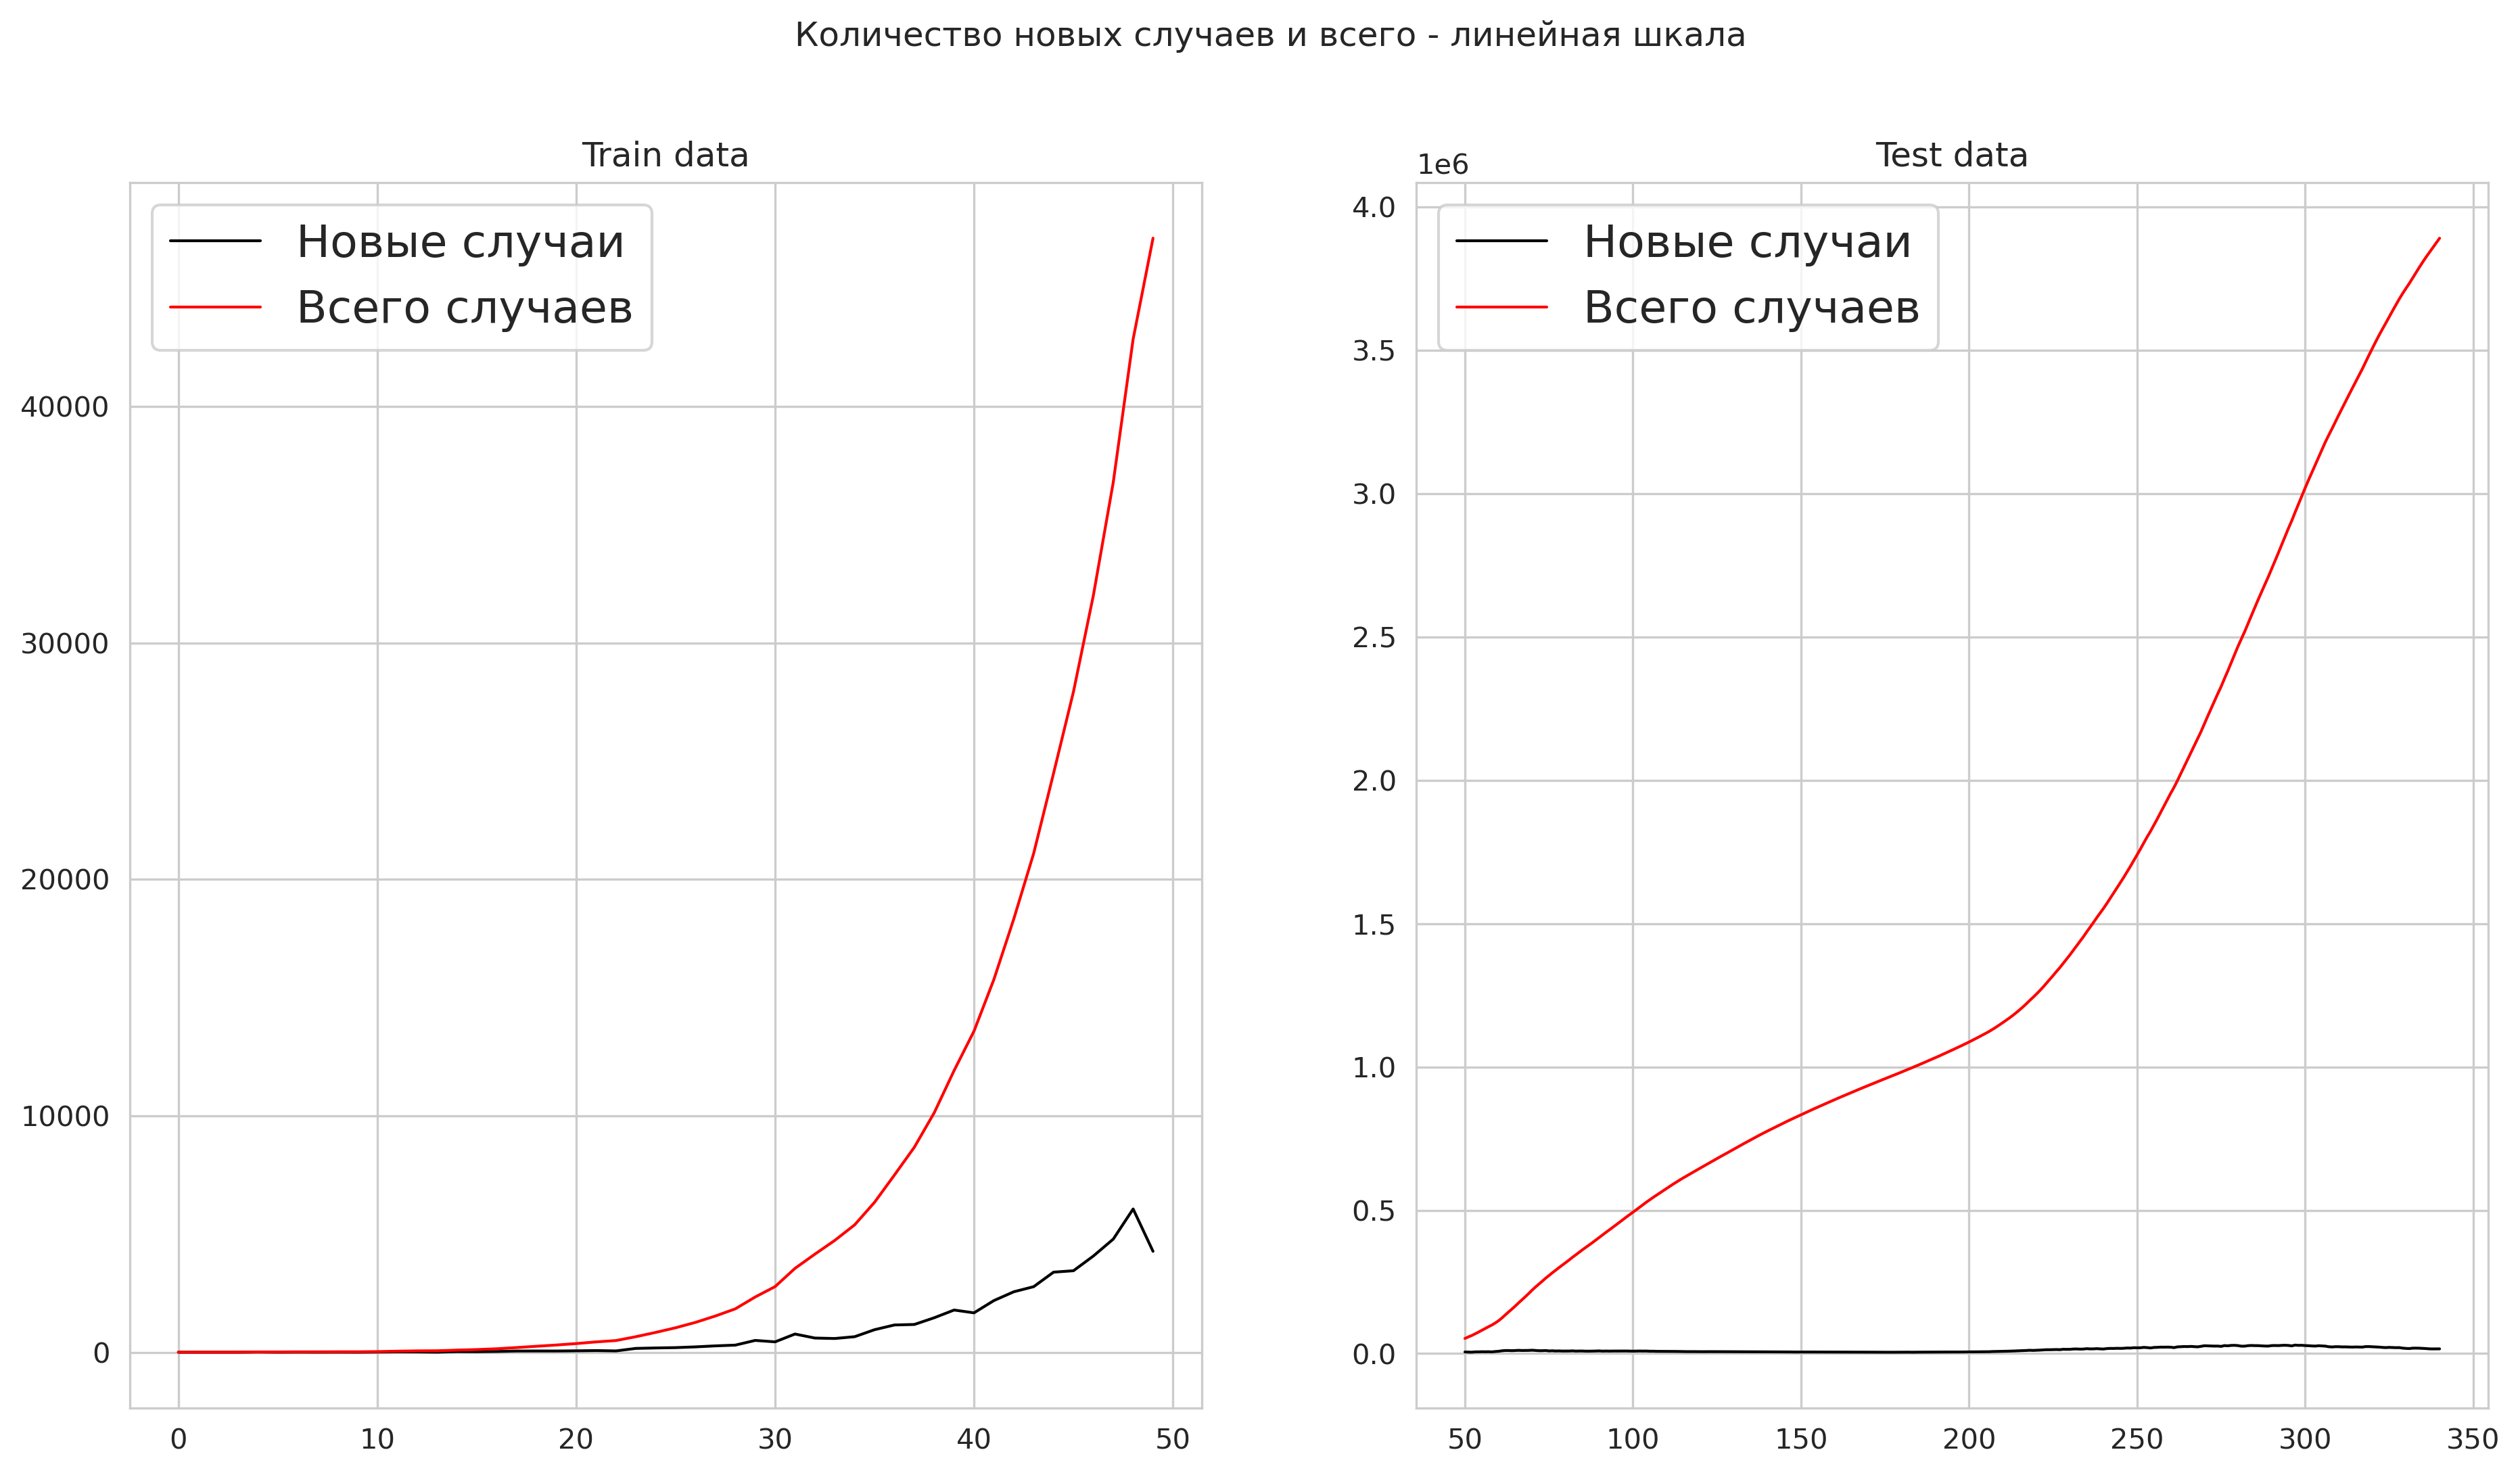

In [13]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(121)

ax.plot(train_df.delta, train_df.new_cases, linewidth=1, label="Новые случаи", color="black")
ax.plot(train_df.delta, train_df.total_cases, linewidth=1, label="Всего случаев", color="red")
ax.set_title('Train data')
ax.legend(loc="upper left", fontsize=legend_fontsize)

ax = fig.add_subplot(122)

ax.plot(test_df.delta, test_df.new_cases, linewidth=1, label="Новые случаи", color="black")
ax.plot(test_df.delta, test_df.total_cases, linewidth=1, label="Всего случаев", color="red")
ax.set_title('Test data')
ax.legend(loc="upper left", fontsize=legend_fontsize)

fig.suptitle('Количество новых случаев и всего - линейная шкала')

plt.show()

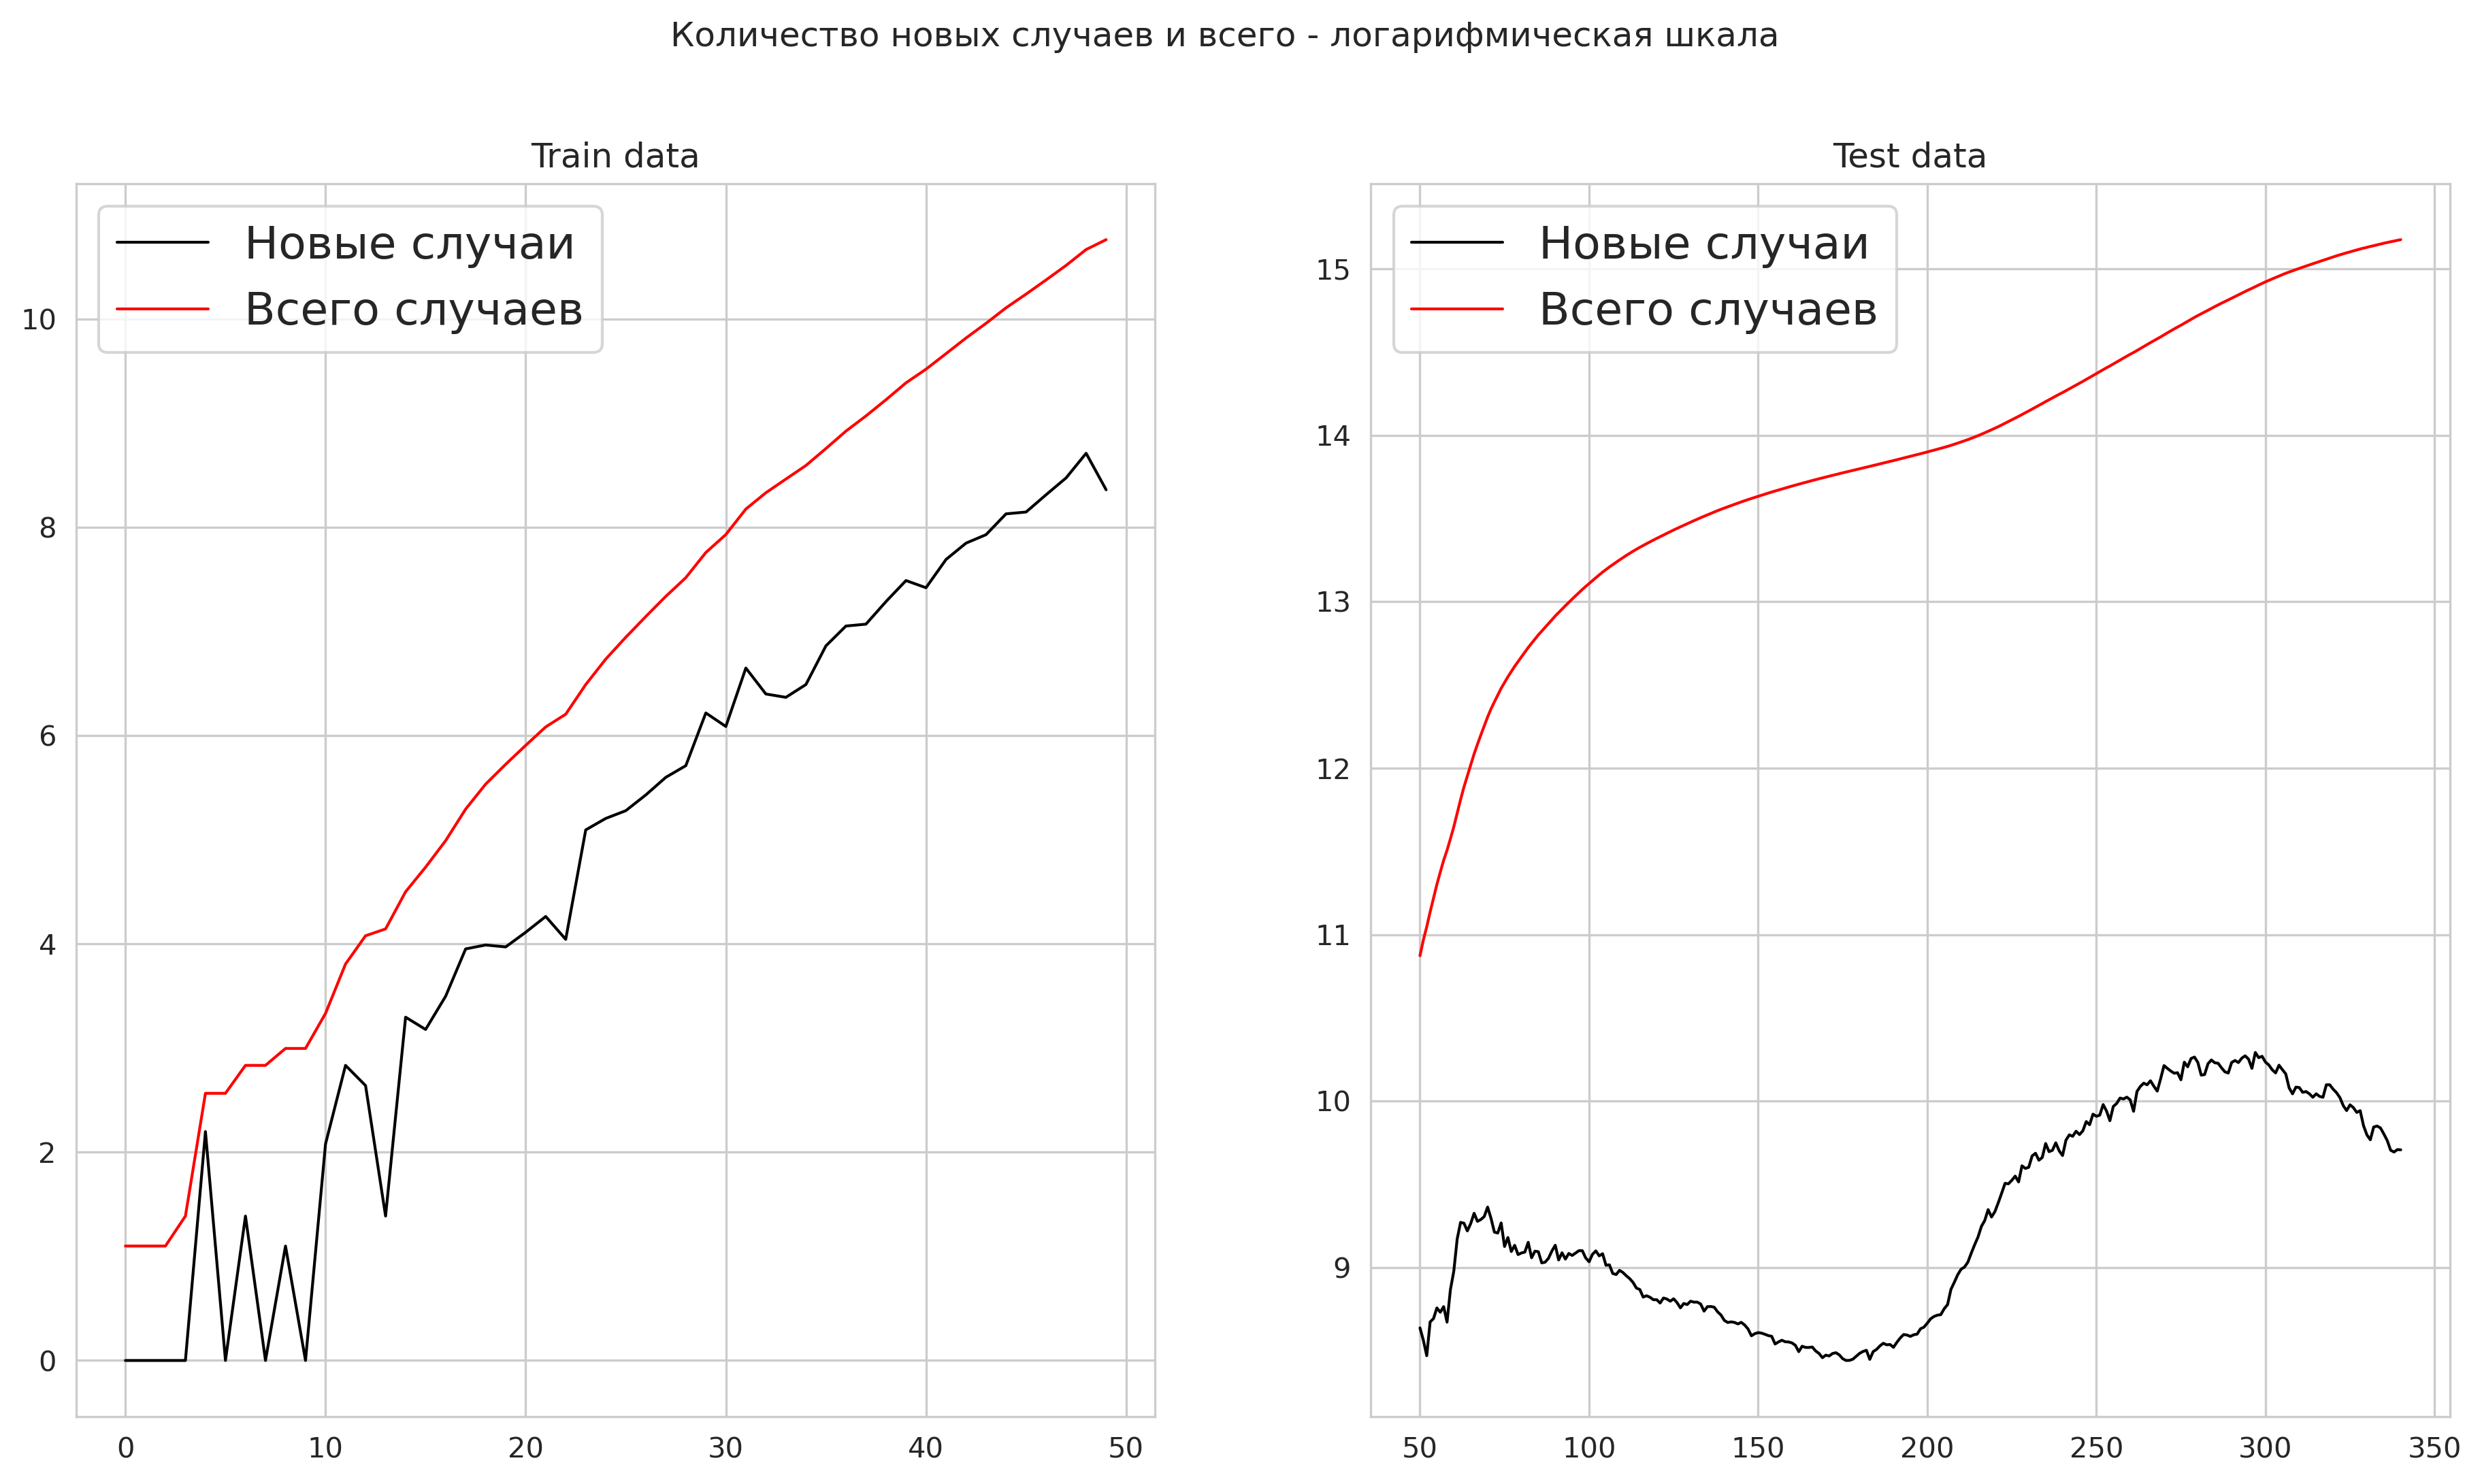

In [14]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(121)

ax.plot(train_df.delta, np.log(train_df.new_cases), linewidth=1, label="Новые случаи", color="black")
ax.plot(train_df.delta, np.log(train_df.total_cases), linewidth=1, label="Всего случаев", color="red")
ax.set_title('Train data')
ax.legend(loc="upper left", fontsize=legend_fontsize)

ax = fig.add_subplot(122)

ax.plot(test_df.delta, np.log(test_df.new_cases), linewidth=1, label="Новые случаи", color="black")
ax.plot(test_df.delta, np.log(test_df.total_cases), linewidth=1, label="Всего случаев", color="red")
ax.set_title('Test data')
ax.legend(loc="upper left", fontsize=legend_fontsize)

fig.suptitle('Количество новых случаев и всего - логарифмическая шкала')

plt.show()

### 2.а - линейная регрессия
Будем учиться предсказывать логарифм общего кол-ва случаев с помощью линейной регрессии

In [15]:
#MAPE metric
EPS = 1e-10
def map_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) / np.abs(y_true + EPS))

In [16]:
x_train = np.array(train_df.delta).reshape(-1, 1)
y_train = np.log(train_df.total_cases)
x_test = np.array(test_df.delta[:10]).reshape(-1, 1)
y_test = np.log(test_df.total_cases[:10])

In [17]:
regr = LinearRegression()
regr.fit(x_train, y_train)
preds = regr.predict(x_test)
print(map_error(y_test, preds))

0.11259591499590615


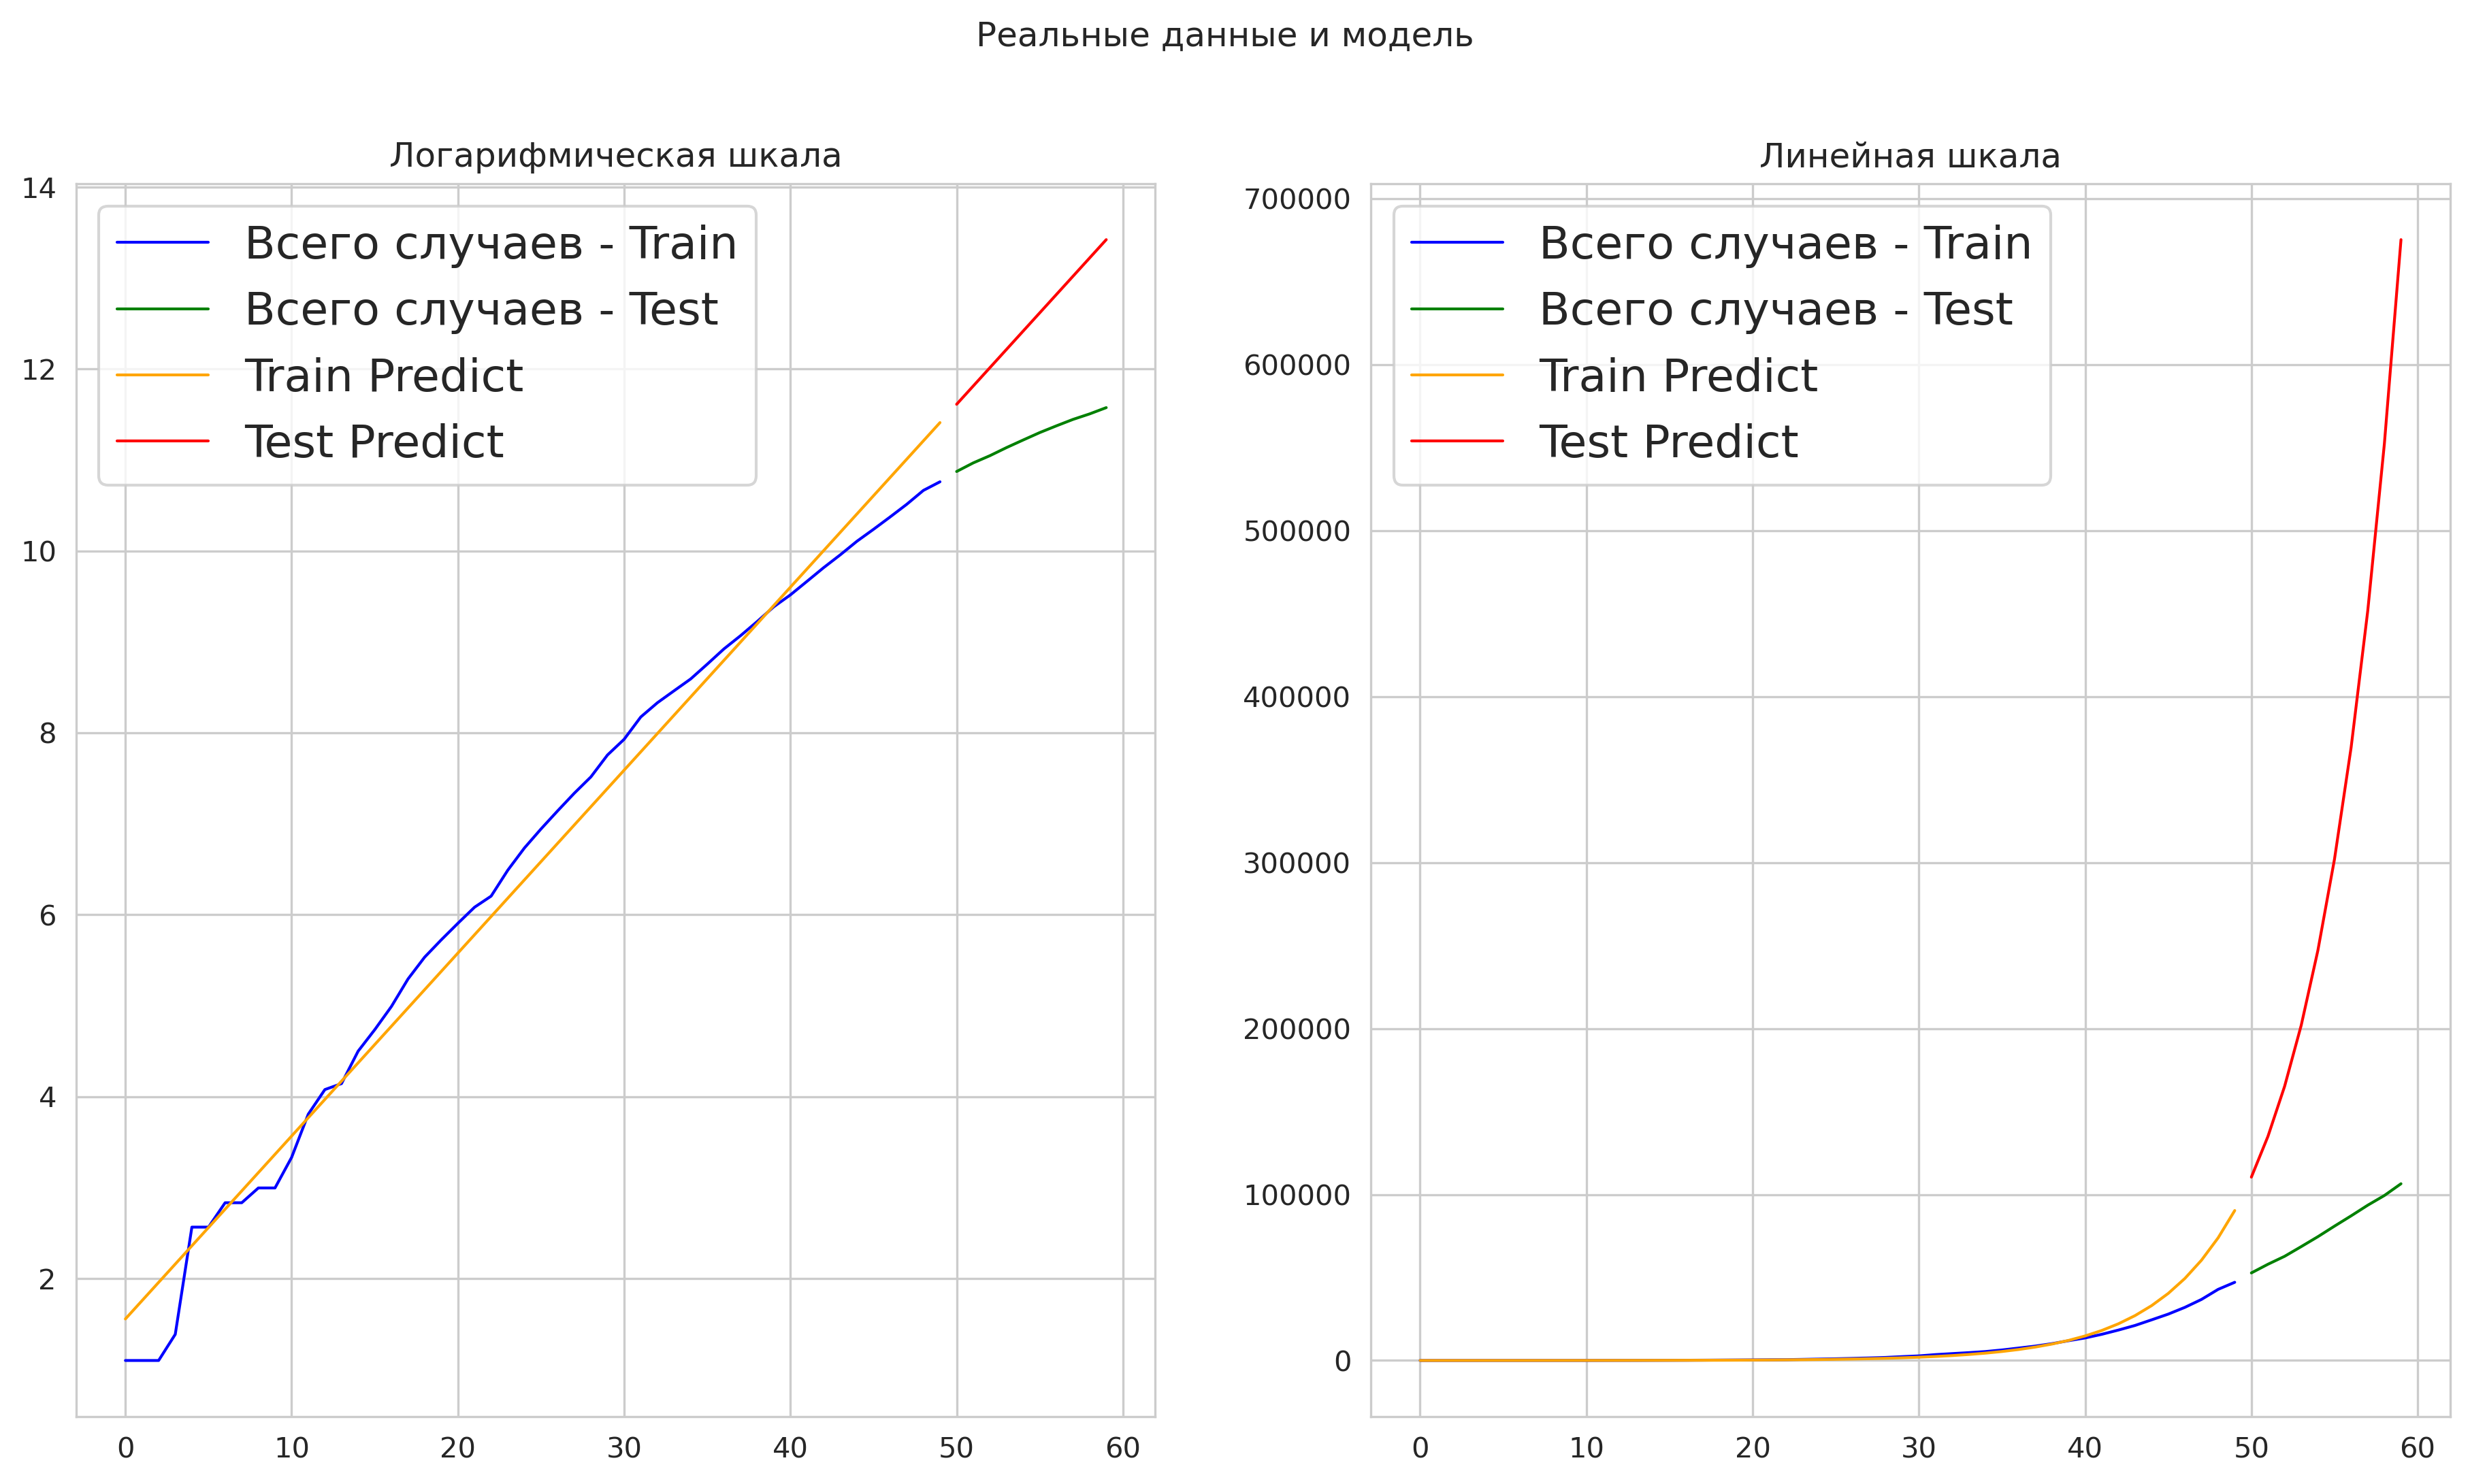

In [18]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(121)

ax.plot(x_train, y_train, linewidth=1, label="Всего случаев - Train", color="blue")
ax.plot(x_test, y_test, linewidth=1, label="Всего случаев - Test", color="green")
ax.plot(x_train, regr.predict(x_train), linewidth=1, label="Train Predict", color="orange")
ax.plot(x_test, regr.predict(x_test), linewidth=1, label="Test Predict", color="red")
ax.set_title('Логарифмическая шкала')
ax.legend(loc="upper left", fontsize=legend_fontsize)

ax = fig.add_subplot(122)

ax.plot(x_train, np.exp(y_train), linewidth=1, label="Всего случаев - Train", color="blue")
ax.plot(x_test, np.exp(y_test), linewidth=1, label="Всего случаев - Test", color="green")
ax.plot(x_train, np.exp(regr.predict(x_train)), linewidth=1, label="Train Predict", color="orange")
ax.plot(x_test, np.exp(regr.predict(x_test)), linewidth=1, label="Test Predict", color="red")
ax.set_title('Линейная шкала')
ax.legend(loc="upper left", fontsize=legend_fontsize)
fig.suptitle('Реальные данные и модель')

plt.show()

### Получается не очень - даже на обучающей выборке расхождение в 2 раза в конце периода

## 2.b Апостериорное распределение

In [19]:
preds = regr.predict(x_train)
mu_1 = np.mean(preds - y_train)
sigma_1 = np.std(preds - y_train)

print(mu_1, sigma_1)

-1.865174681370263e-16 0.34177165872773135


In [20]:
N = 250
xs = np.linspace(-3, 3, N)
X = np.linspace(-1, 1, N)
Y = np.linspace(-1, 1, N)
X, Y = np.meshgrid(X, Y)

pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

def myplot_heatmap(Z):
    # Make the plot
    plt.axis('equal')
    plt.xlim((-1, 1))
    plt.ylim((-1, 1))
    plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)
#     plt.scatter(true_mu[0], true_mu[1], marker='*', s=120)

(250, 250)


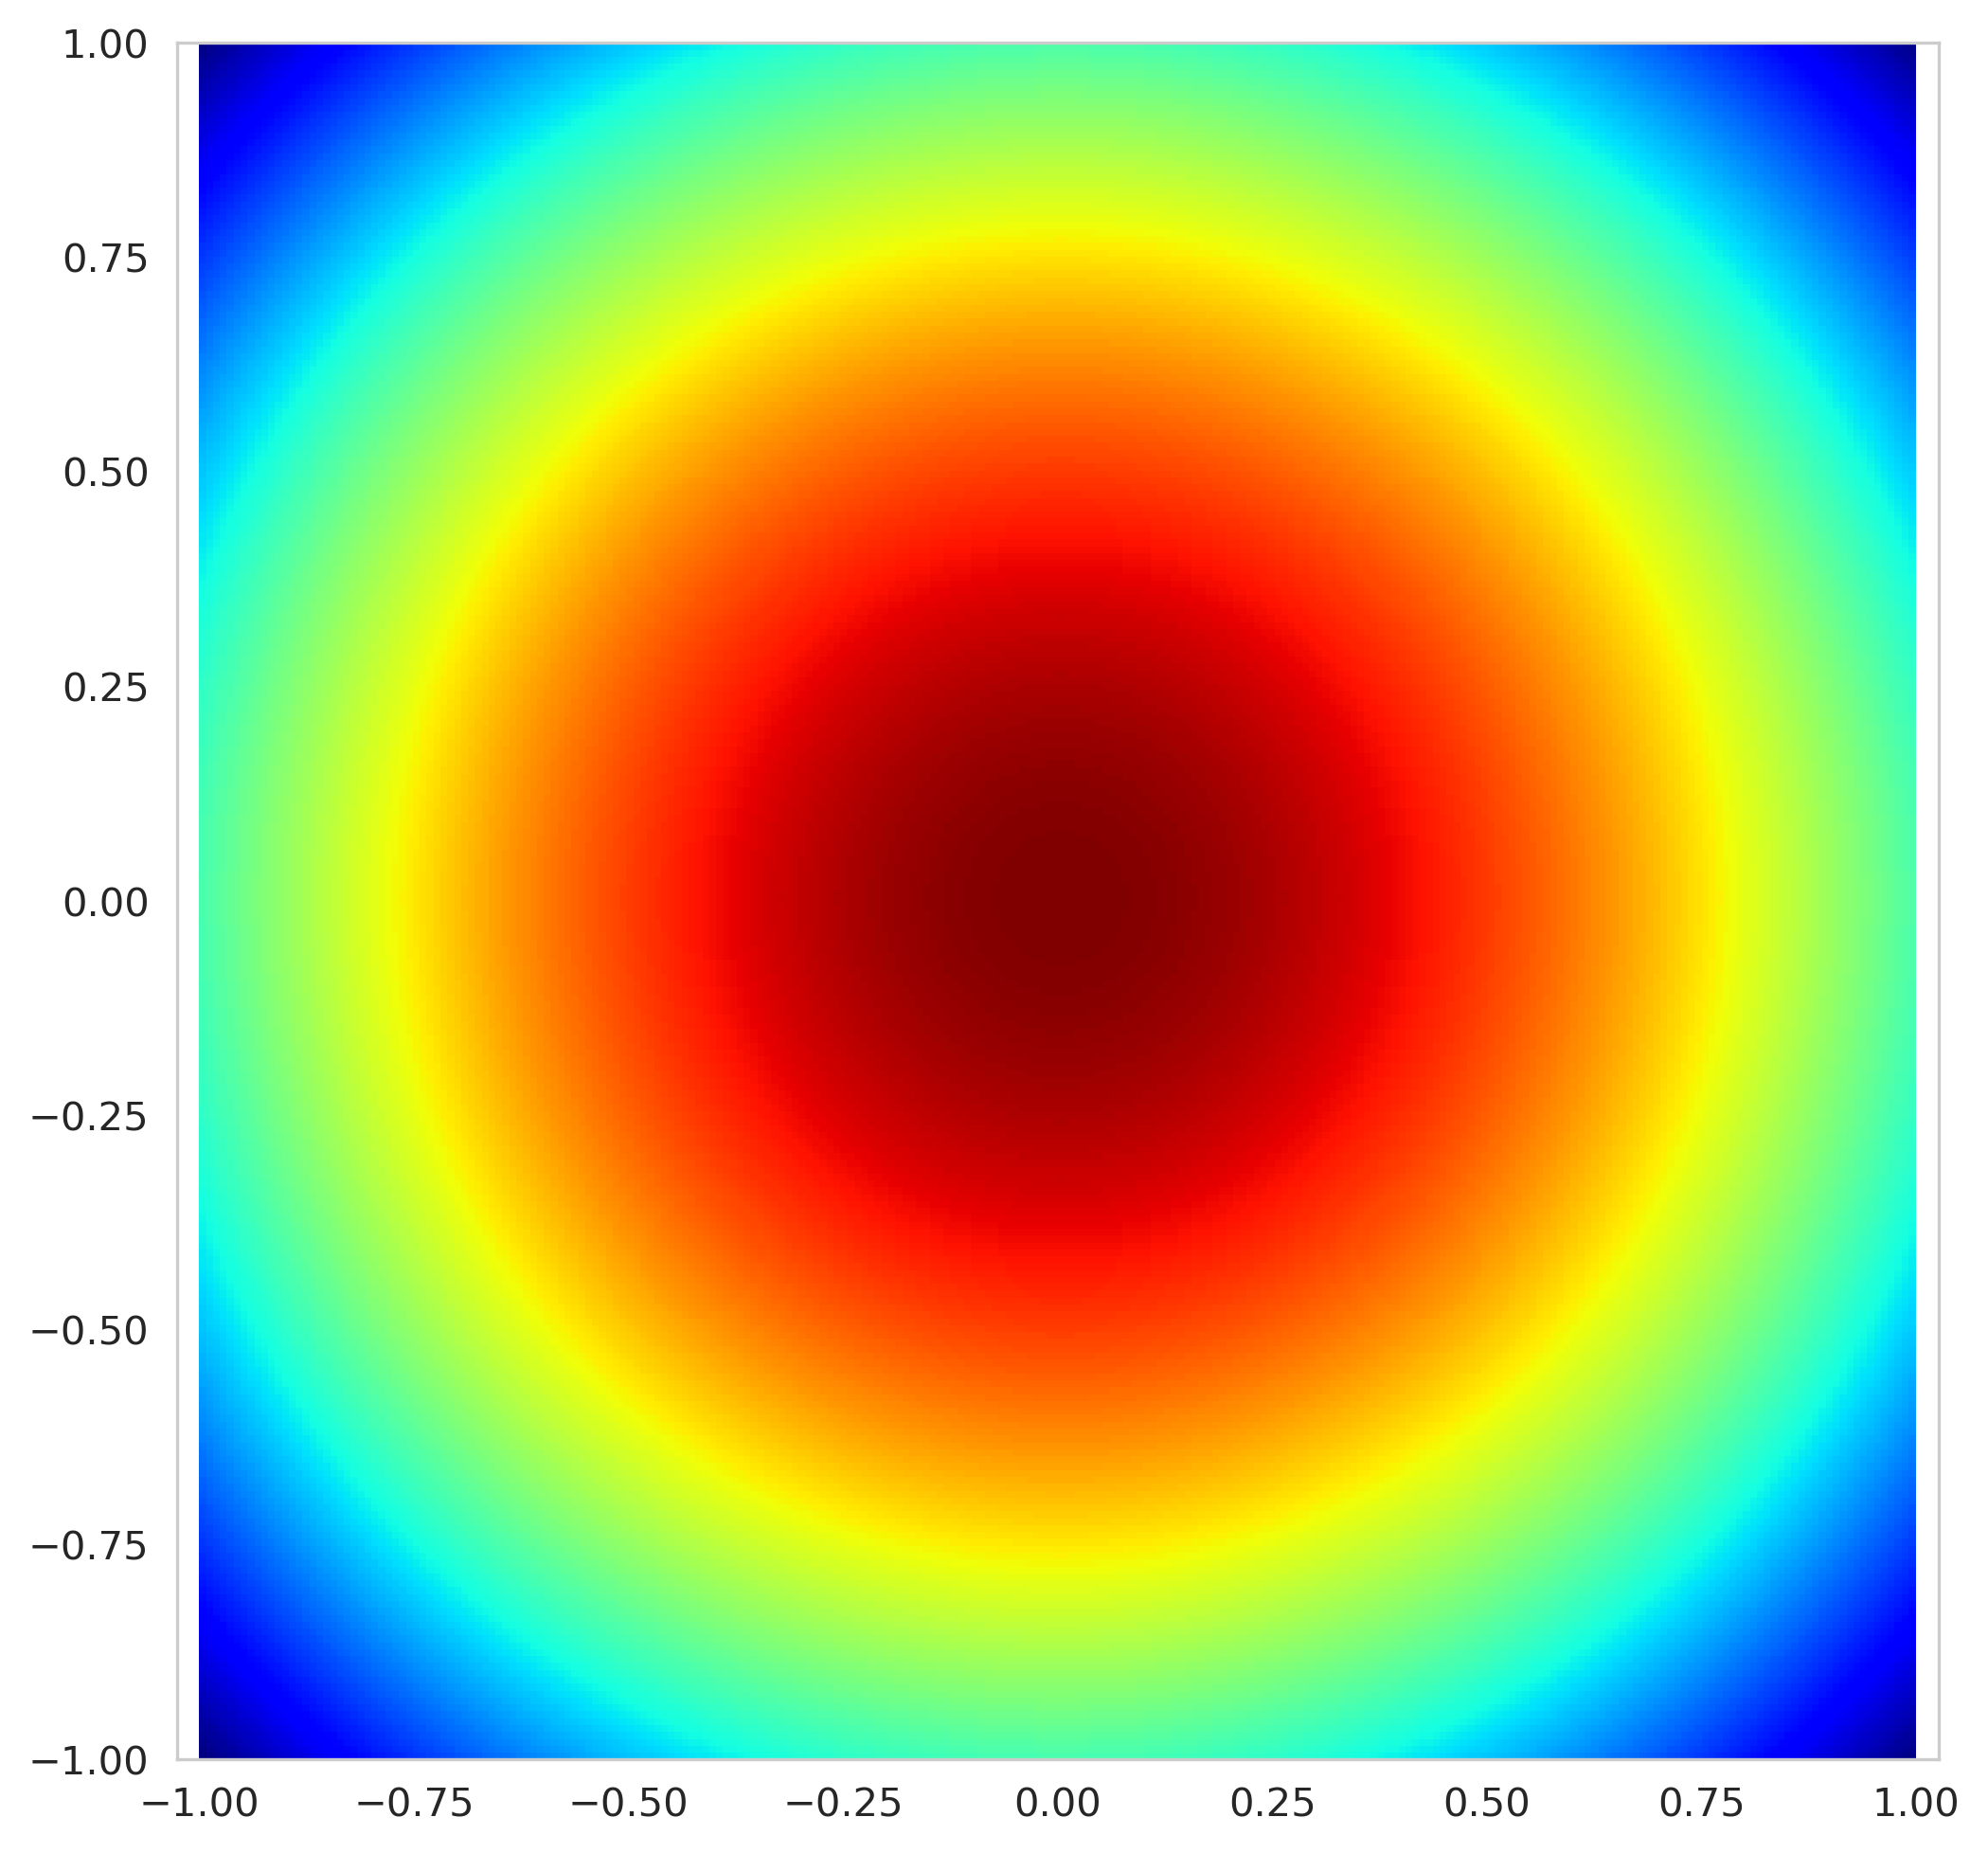

In [21]:
cur_mu, cur_sigma = np.array([0., 0.]), 2*np.array([[1., 0.], [0., 1.]])

Z = scipy.stats.multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)
print(Z.shape)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-2, 2))
myplot_heatmap(Z)

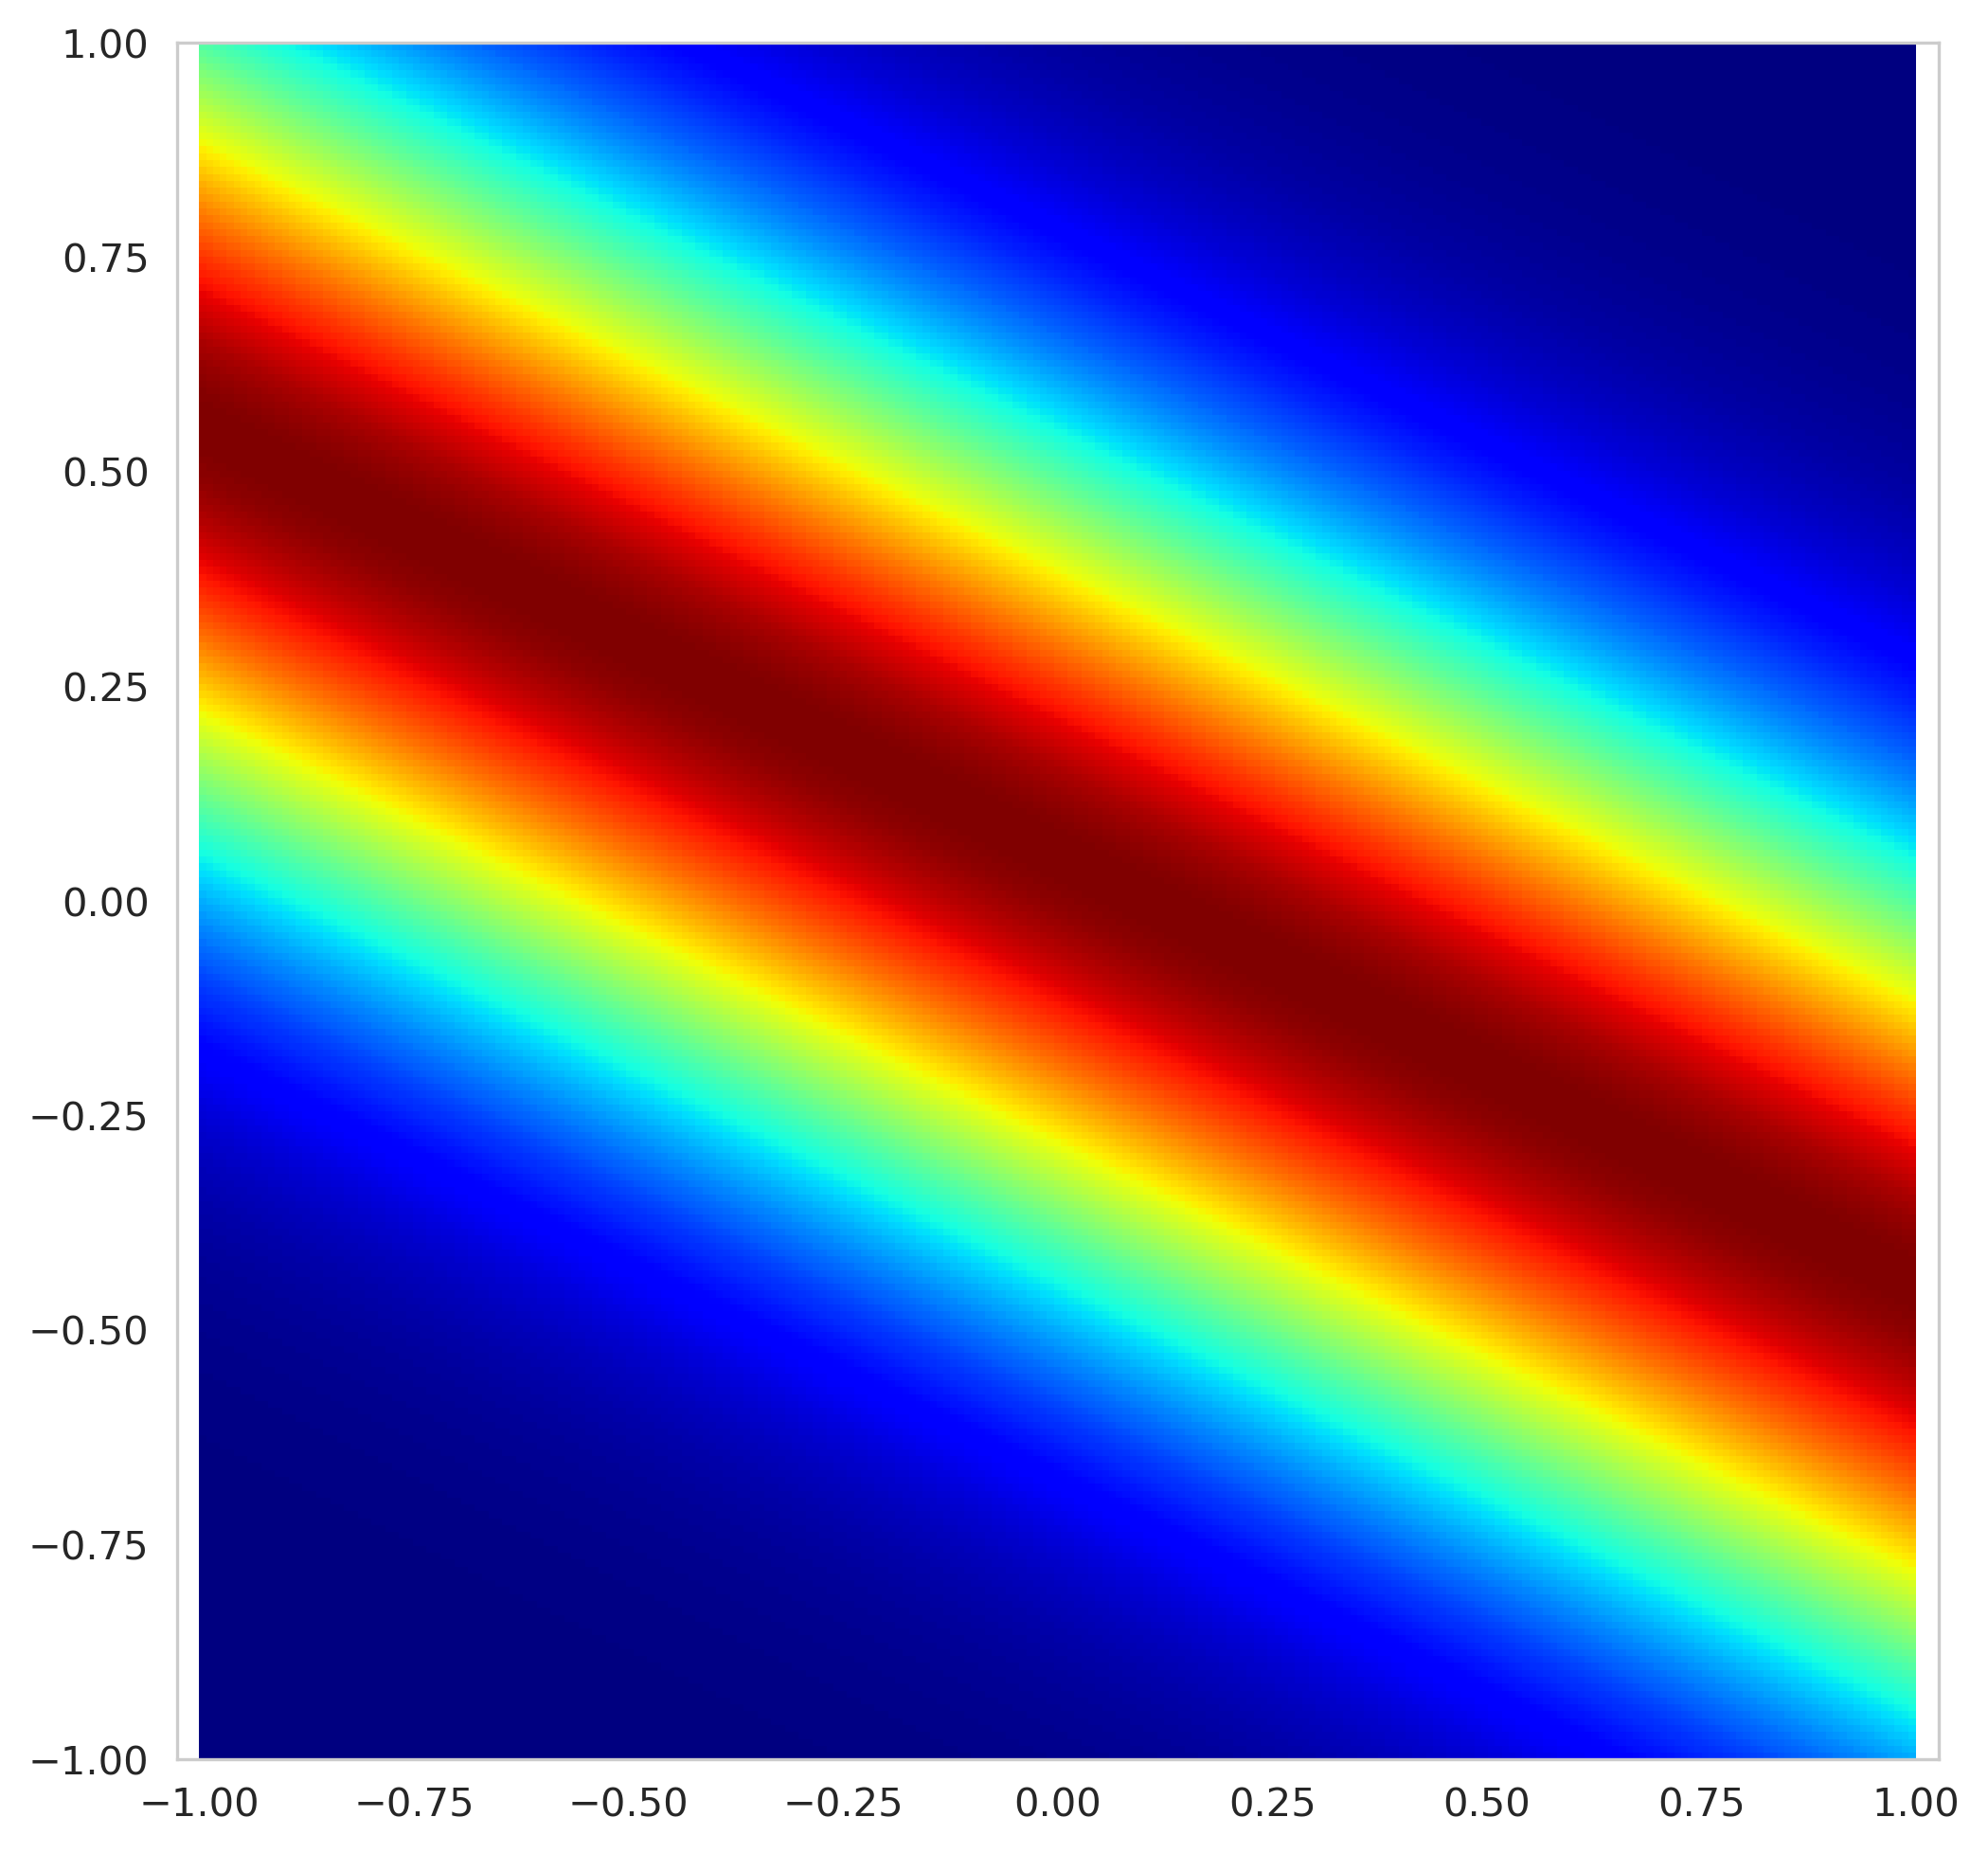

In [22]:
def get_likelihood(px, py, sigma):
#     print(px, py, sigma)
    return lambda x : np.exp(-(x[0] + x[1]*px - py) ** 2) / (2 * sigma * np.sqrt(2.*np.pi))

px, py = x_train[2], np.log(y_train.values[2])
cur_likelihood = get_likelihood(px, py, 0.5)
Z = np.array([[ cur_likelihood(pos[i, j]) for j in range(pos.shape[1])] for i in range(pos.shape[0])])

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-2, 2))
myplot_heatmap(Z[...,0])

In [23]:
def bayesian_update(mu, sigma, x, y, sigma_noise=.25):
    x_matrix = np.array([[1, x]], dtype='float')
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * 
                            np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2))
                     * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

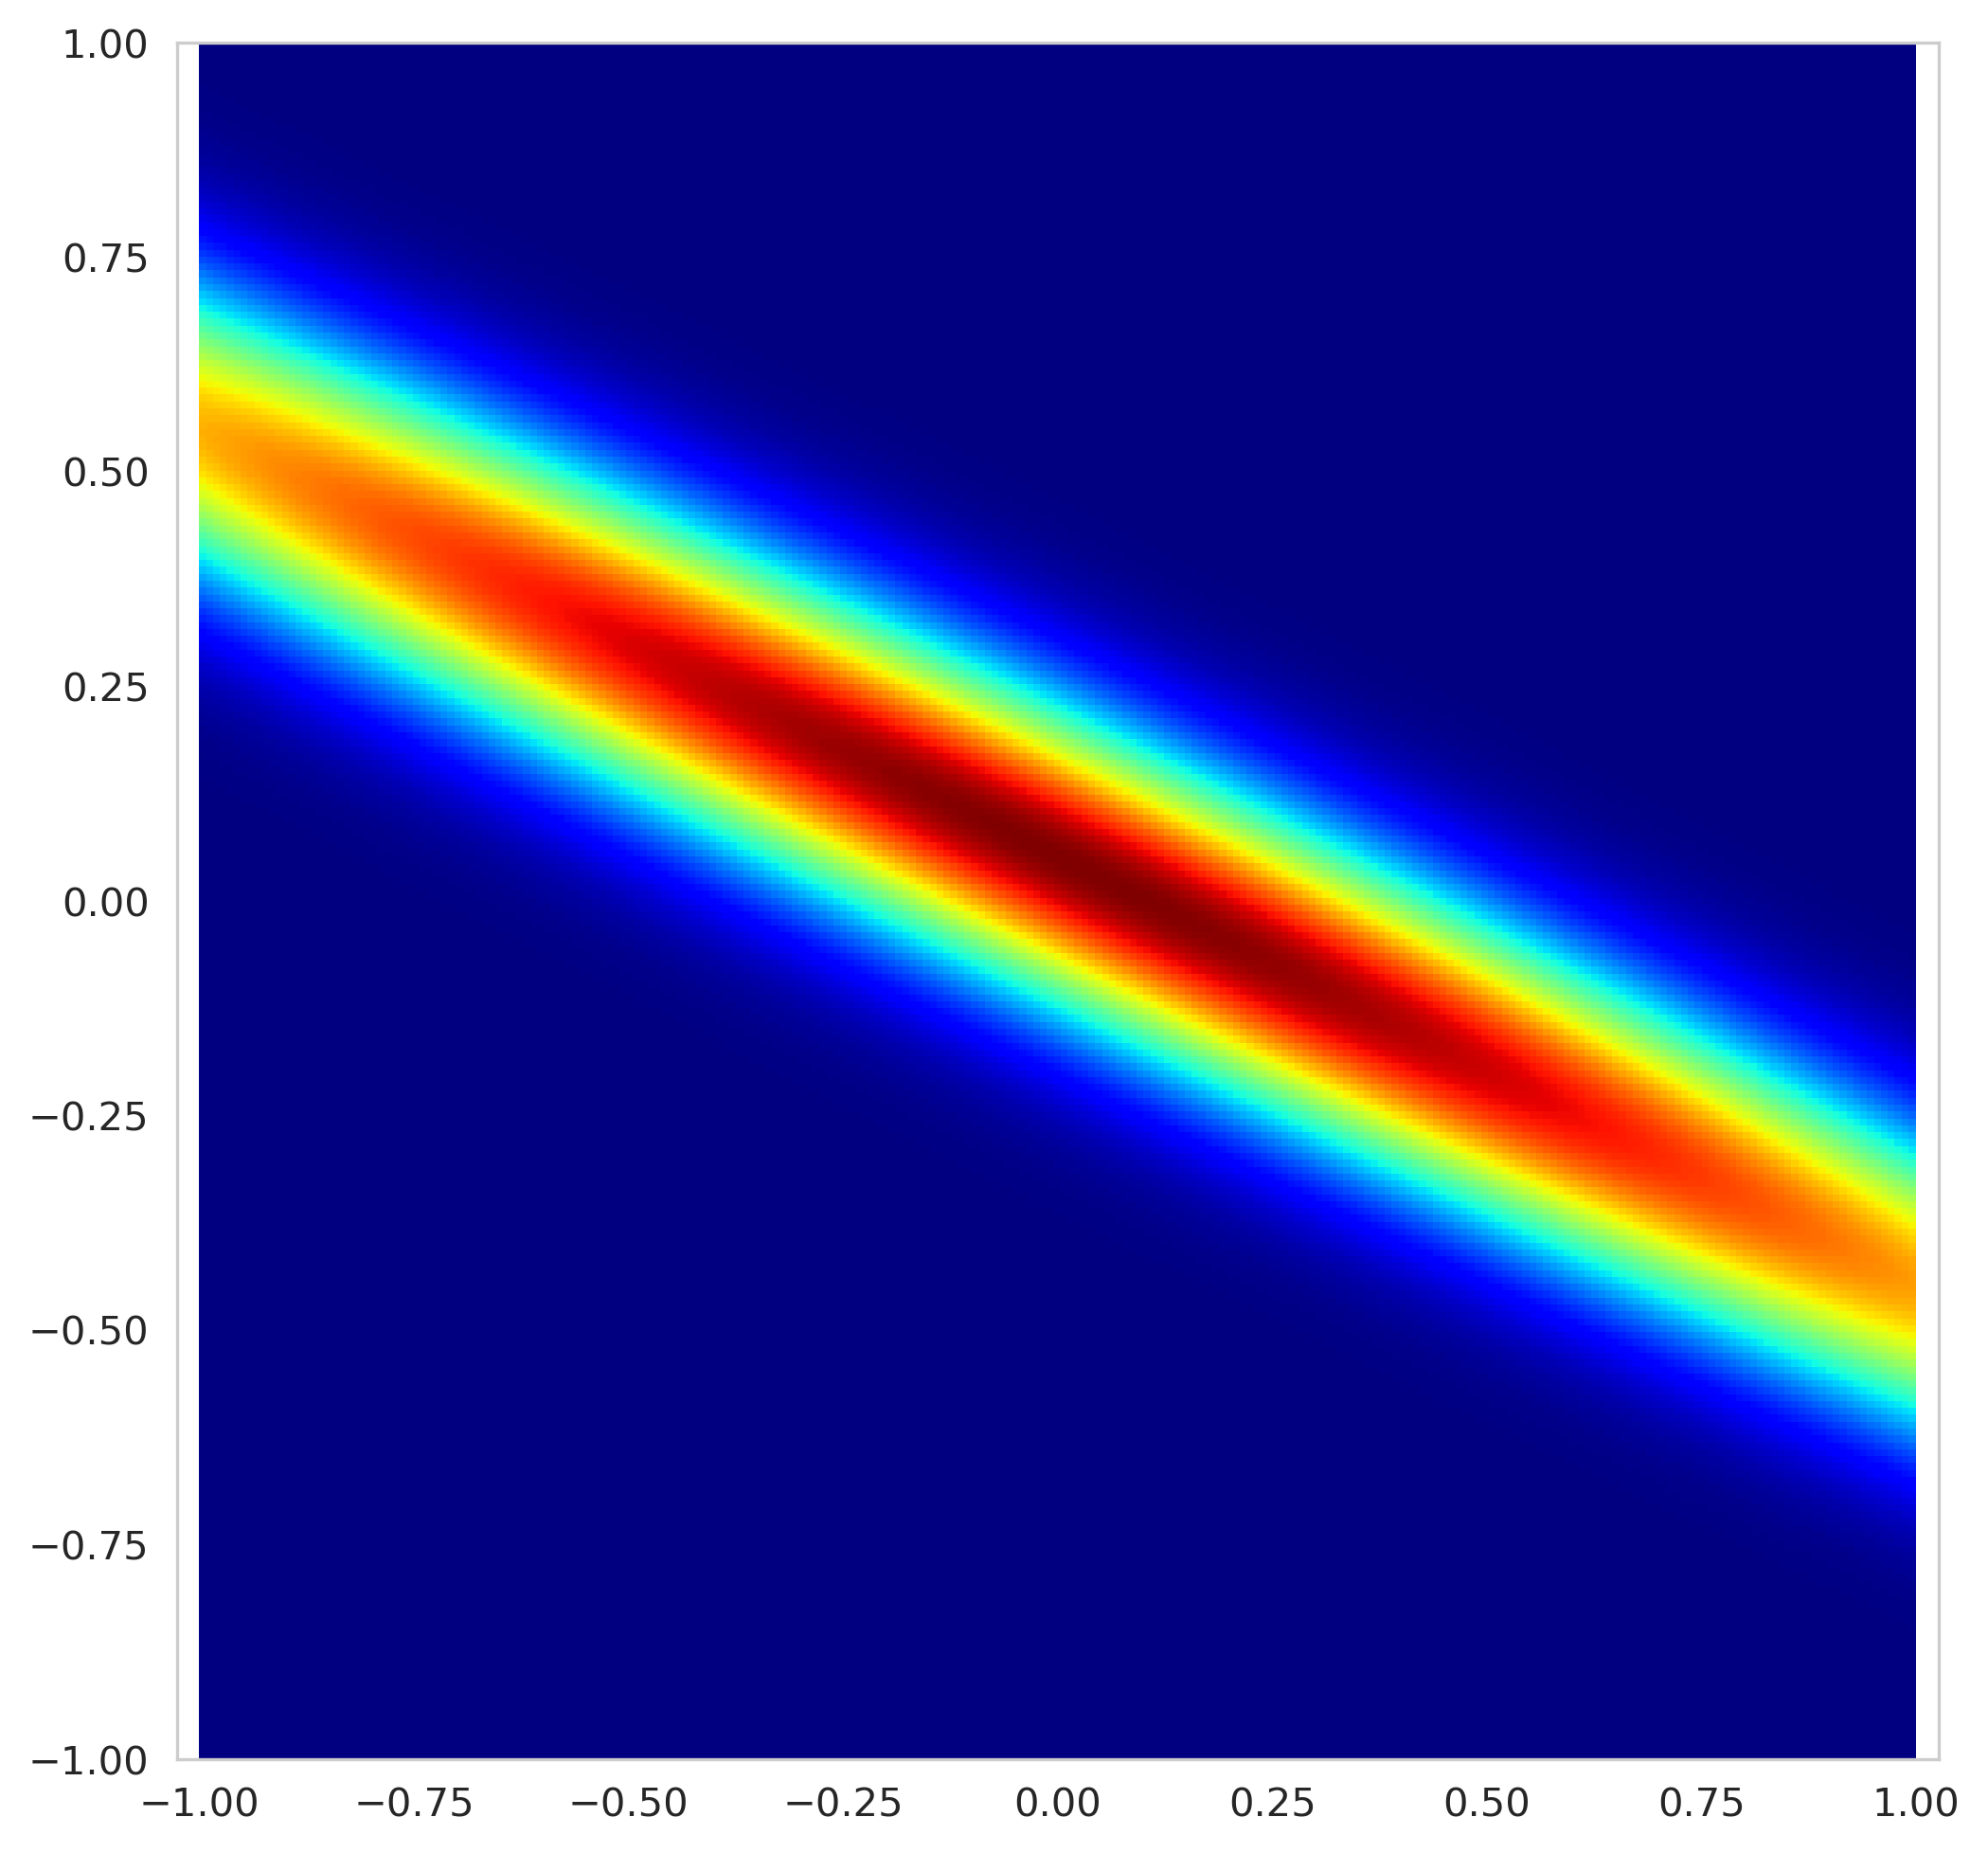

In [24]:
cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, px, py)
Z = scipy.stats.multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-2, 2))
myplot_heatmap(Z)

In [25]:
print(f'New MU: {cur_mu}, New Sigma: {cur_sigma}')

New MU: [0.01869274 0.03738547], New Sigma: [[ 1.60248447 -0.79503106]
 [-0.79503106  0.40993789]]


## 2.c Сэмплирование

In [26]:
xs = np.linspace(0, 100, 1000)

In [27]:
def myplot_sample_lines(mu, sigma, n=20, points=None, use_exp=False):
    # Посэмплируем и порисуем прямые
    my_w = np.random.multivariate_normal(mu, sigma, n)

    # plt.axis('equal')
    for w in my_w:
        if use_exp:
            plt.plot(xs, np.exp(w[0] + w[1]*xs), 'k-', lw=.4)
        else:
            plt.plot(xs, w[0] + w[1]*xs, 'k-', lw=.4)
#     plt.ylim((-3, 3))
#     plt.xlim((-3, 3))
    if not points is None:
        plt.scatter(points[0], points[1], marker='*', s=200)

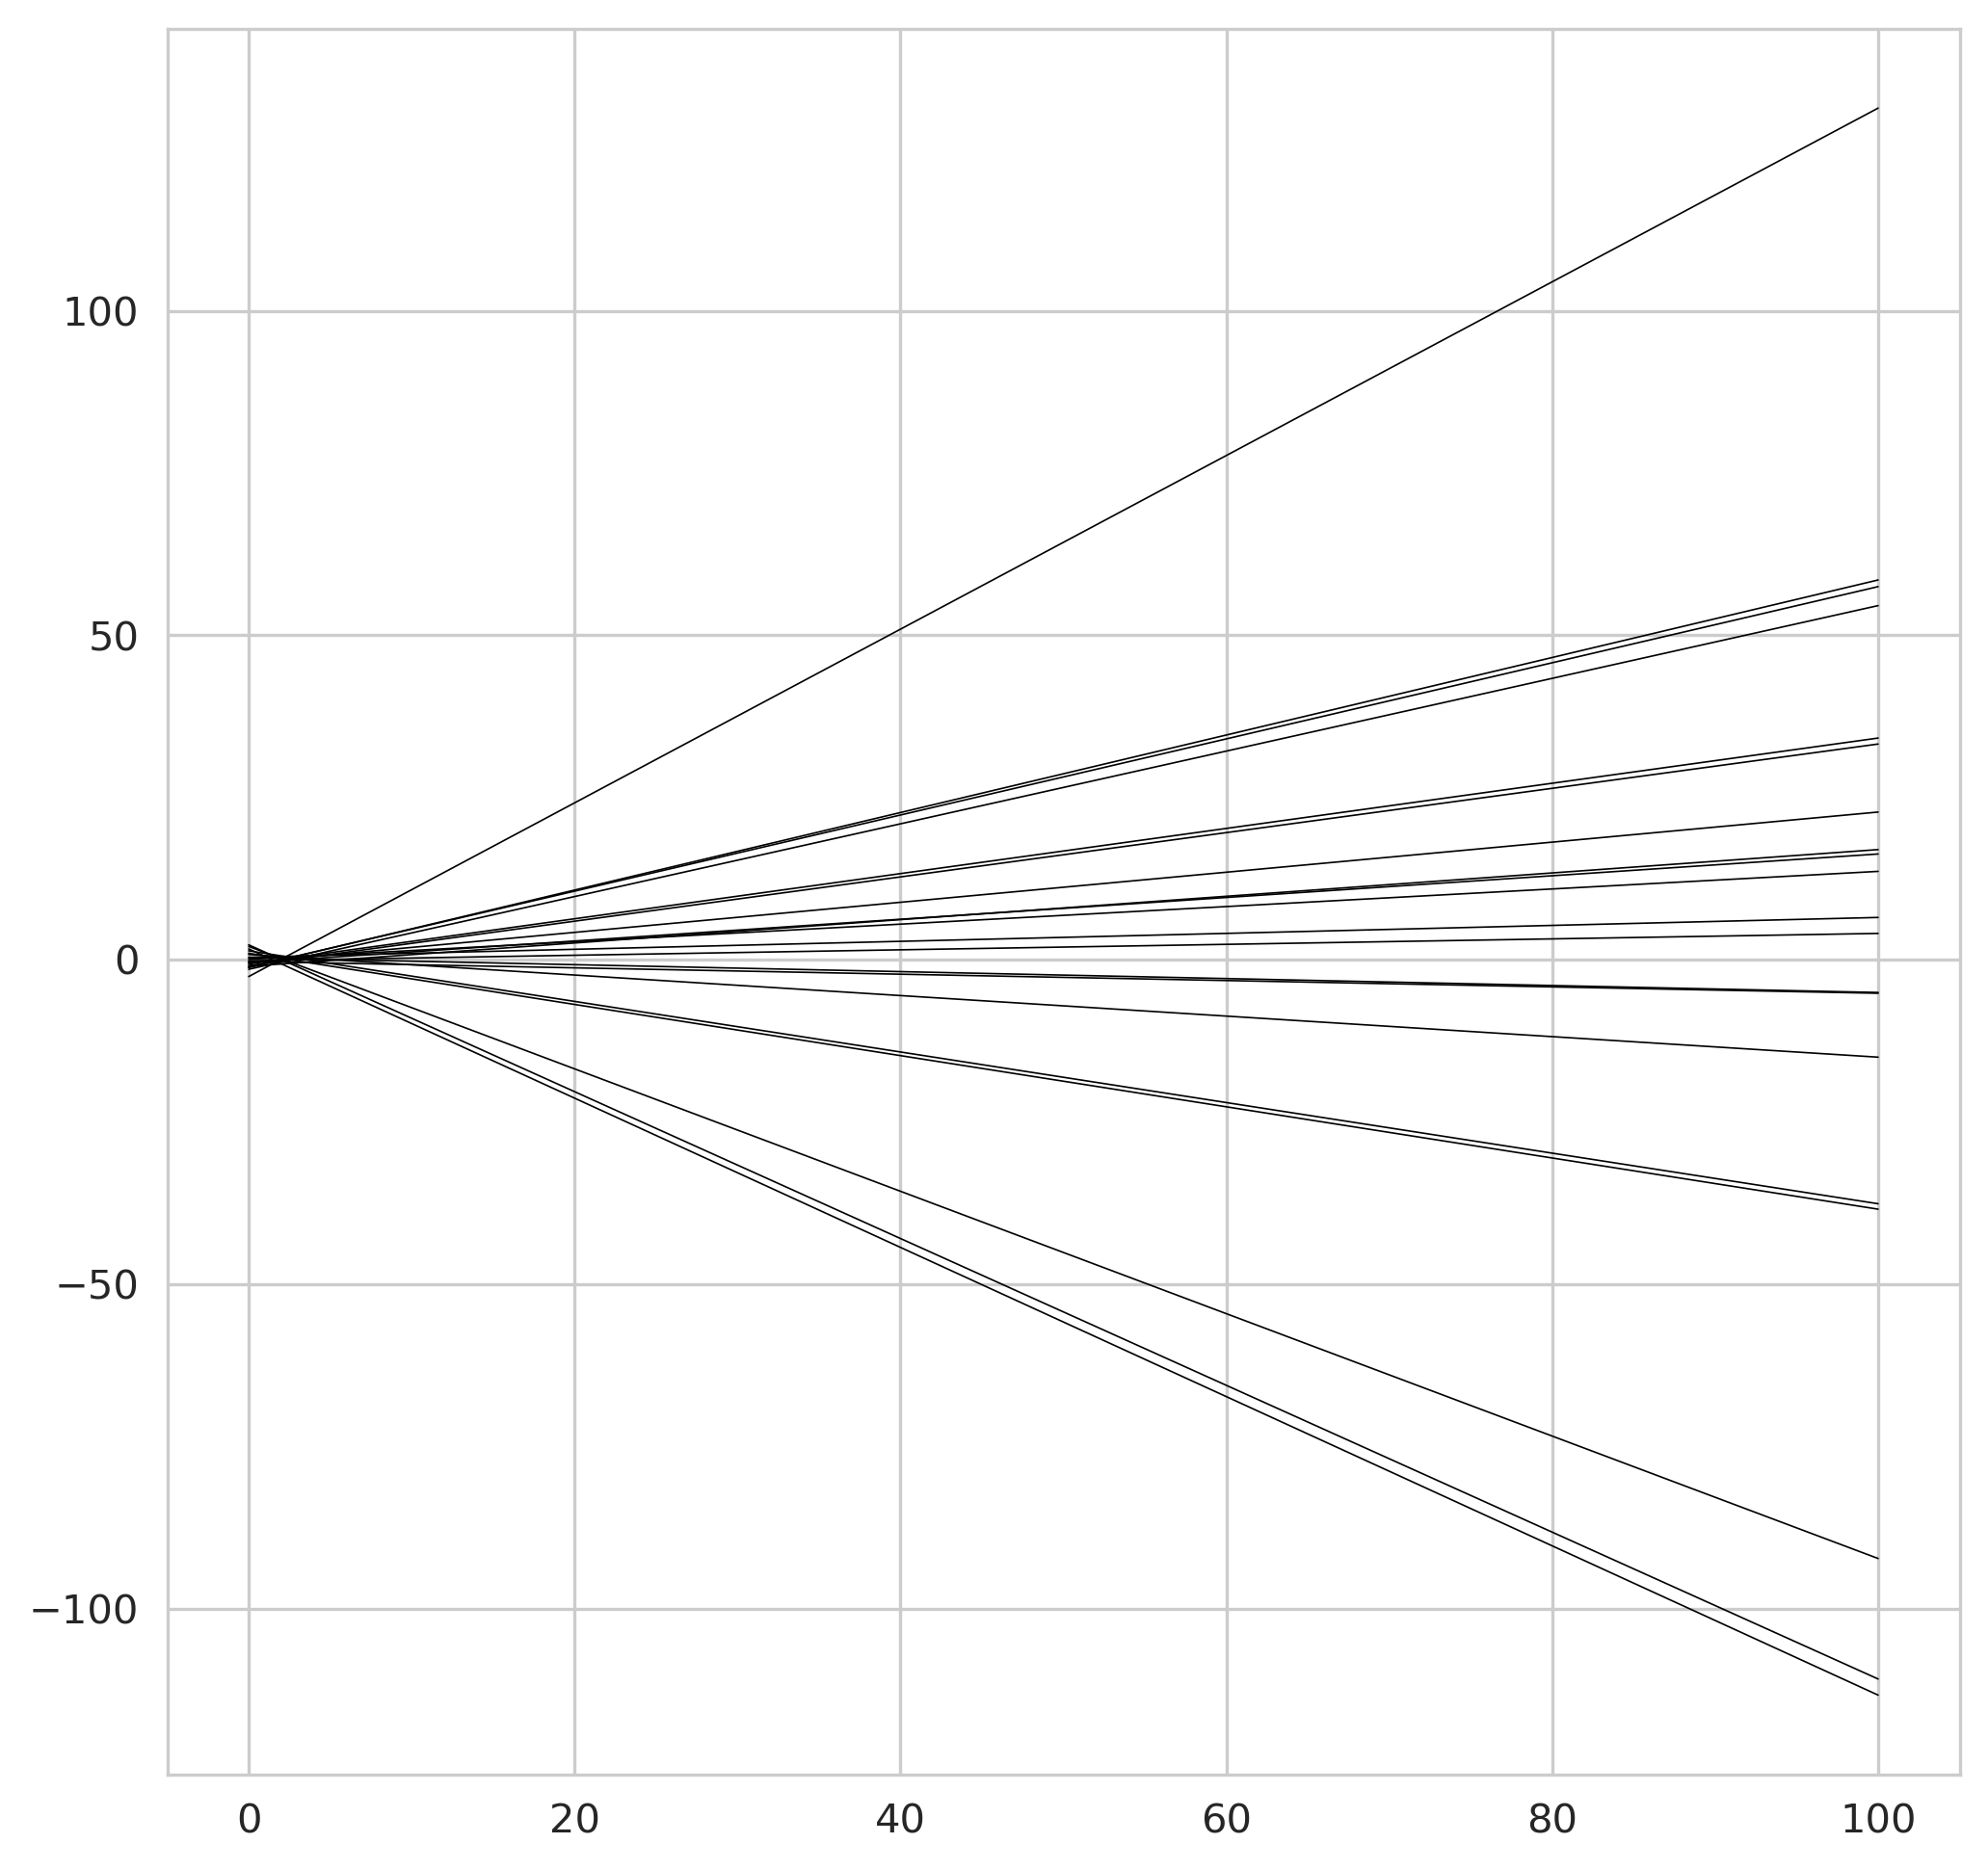

In [28]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
# ax.set_xlim((0, 70))
# ax.set_ylim((-2, 2))
myplot_sample_lines(cur_mu, cur_sigma, 20)

Выше приведены сэмплы показателей экспонент. Рисовать сами экспоненты особого смысла нет - они делятся на две категории:
 - с отрицательным углом - предсказывают ноль
 - с положительным углом - предсказывают крайне большие величины, не имеющие отношения к реальности

Даже лучшая модель на 60-й день (2-е мая) предсказывает около 700 000 случаев, что в 6 раз больше реального значения.

# 3 Предсказание сигмоидой

## 3.a Способ обучения

Пусть наша кривая общего количества заболевших имеет вид: 
$$F(x) = \int_{-\infty}^{x} e^{a x^2 + b x + c} dx$$
Тогда ее производная или количество заболевших в день (столбец new_cases) имеет вид:
$$e^{a x^2 + b x + c}$$
Взяв логарифм получаем:
$$log(new\_cases) = a x^2 + b x + c$$
А эту задачу можно решить обычной линейной регрессией, взяв $x$ и $x^2$ в качестве признаков

## 3.b Обучение

In [29]:
#Увеличено кол-во случаев в тестовой выборке для наглядности
x_train = np.array(train_df.delta).reshape(-1, 1)
y_train = np.log(train_df.new_cases)
x_test = np.array(test_df.delta[:100]).reshape(-1, 1)
y_test = np.log(test_df.new_cases[:100])

In [30]:
# Adding new feature x^2
x_train = np.hstack((x_train, x_train ** 2))
x_test = np.hstack((x_test, x_test ** 2))

In [31]:
regr = LinearRegression()
regr.fit(x_train, y_train)
preds = regr.predict(x_test)
print(map_error(y_test, preds))

0.1682297294615281


In [32]:
regr.coef_, regr.intercept_

(array([ 0.26944398, -0.00165749]), -0.5572697535965396)

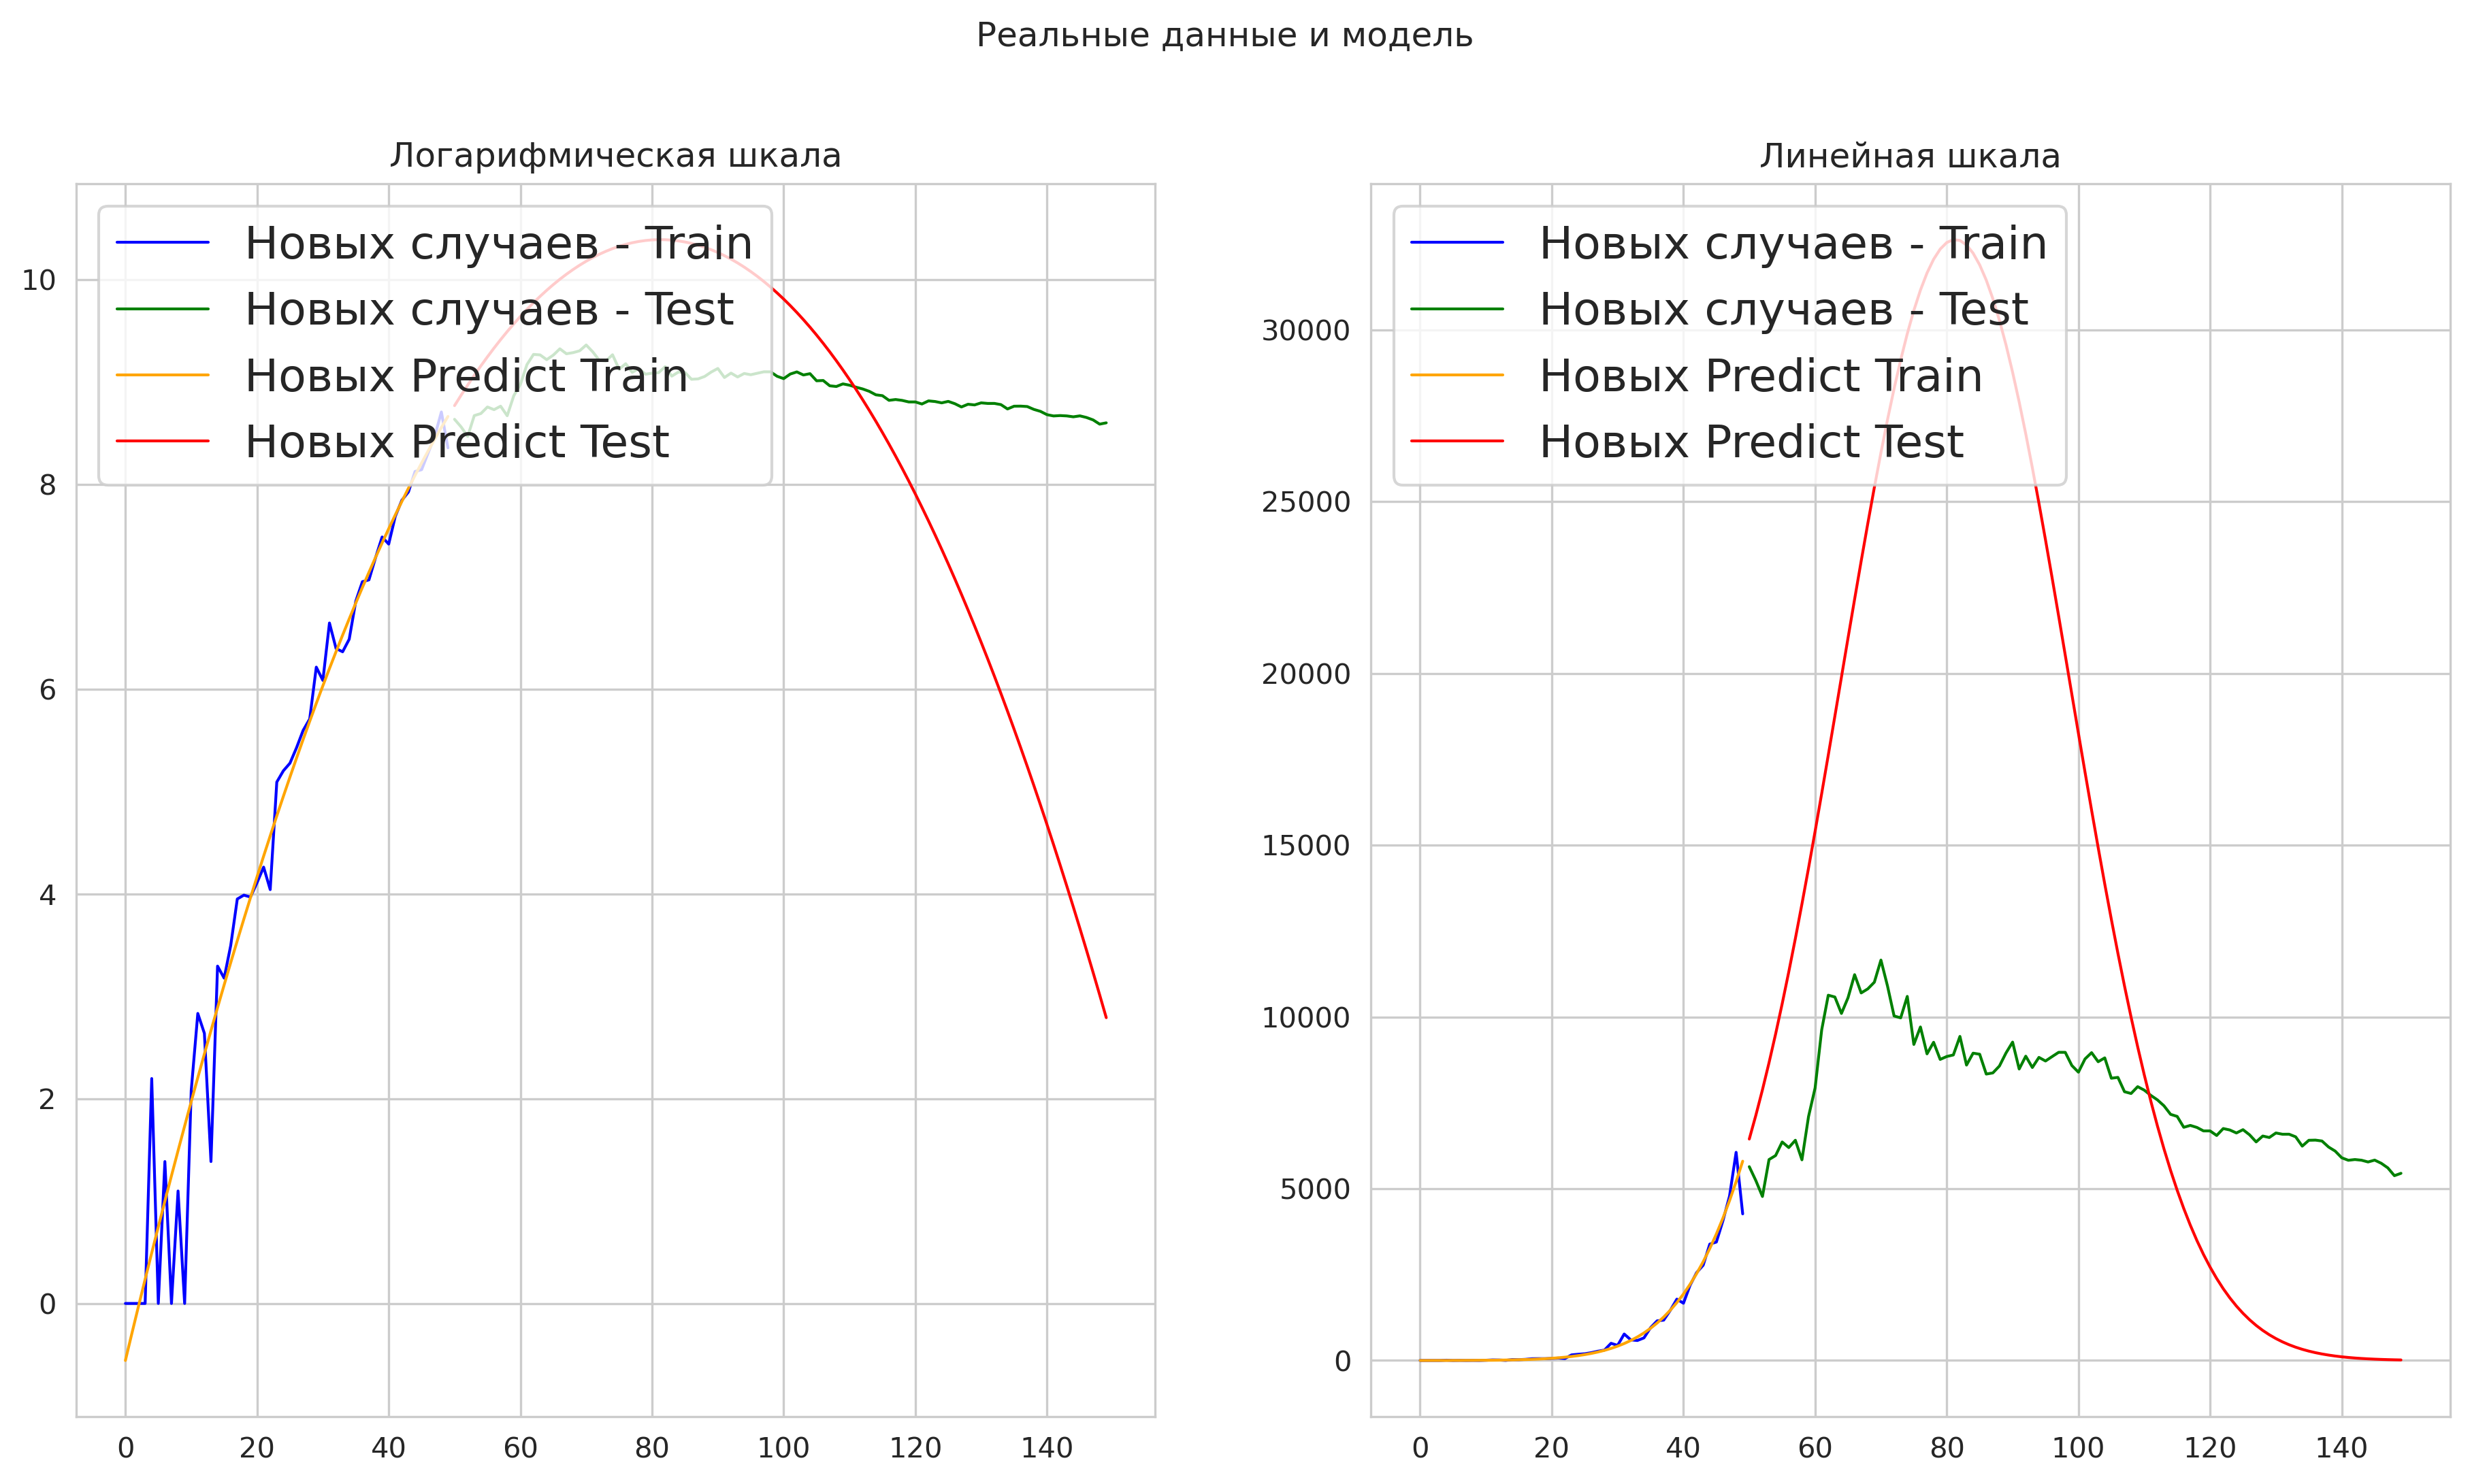

In [33]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(121)

ax.plot(x_train[..., 0], y_train, linewidth=1, label="Новых случаев - Train", color="blue")
ax.plot(x_test[..., 0], y_test, linewidth=1, label="Новых случаев - Test", color="green")
ax.plot(x_train[..., 0], regr.predict(x_train), linewidth=1, label="Новых Predict Train", color="orange")
ax.plot(x_test[..., 0], regr.predict(x_test), linewidth=1, label="Новых Predict Test", color="red")
ax.set_title('Логарифмическая шкала')
ax.legend(loc="upper left", fontsize=legend_fontsize)

ax = fig.add_subplot(122)

ax.plot(x_train[..., 0], np.exp(y_train), linewidth=1, label="Новых случаев - Train", color="blue")
ax.plot(x_test[..., 0], np.exp(y_test), linewidth=1, label="Новых случаев - Test", color="green")
ax.plot(x_train[..., 0], np.exp(regr.predict(x_train)), linewidth=1, label="Новых Predict Train", color="orange")
ax.plot(x_test[..., 0], np.exp(regr.predict(x_test)), linewidth=1, label="Новых Predict Test", color="red")
ax.set_title('Линейная шкала')
ax.legend(loc="upper left", fontsize=legend_fontsize)
fig.suptitle('Реальные данные и модель')

plt.show()

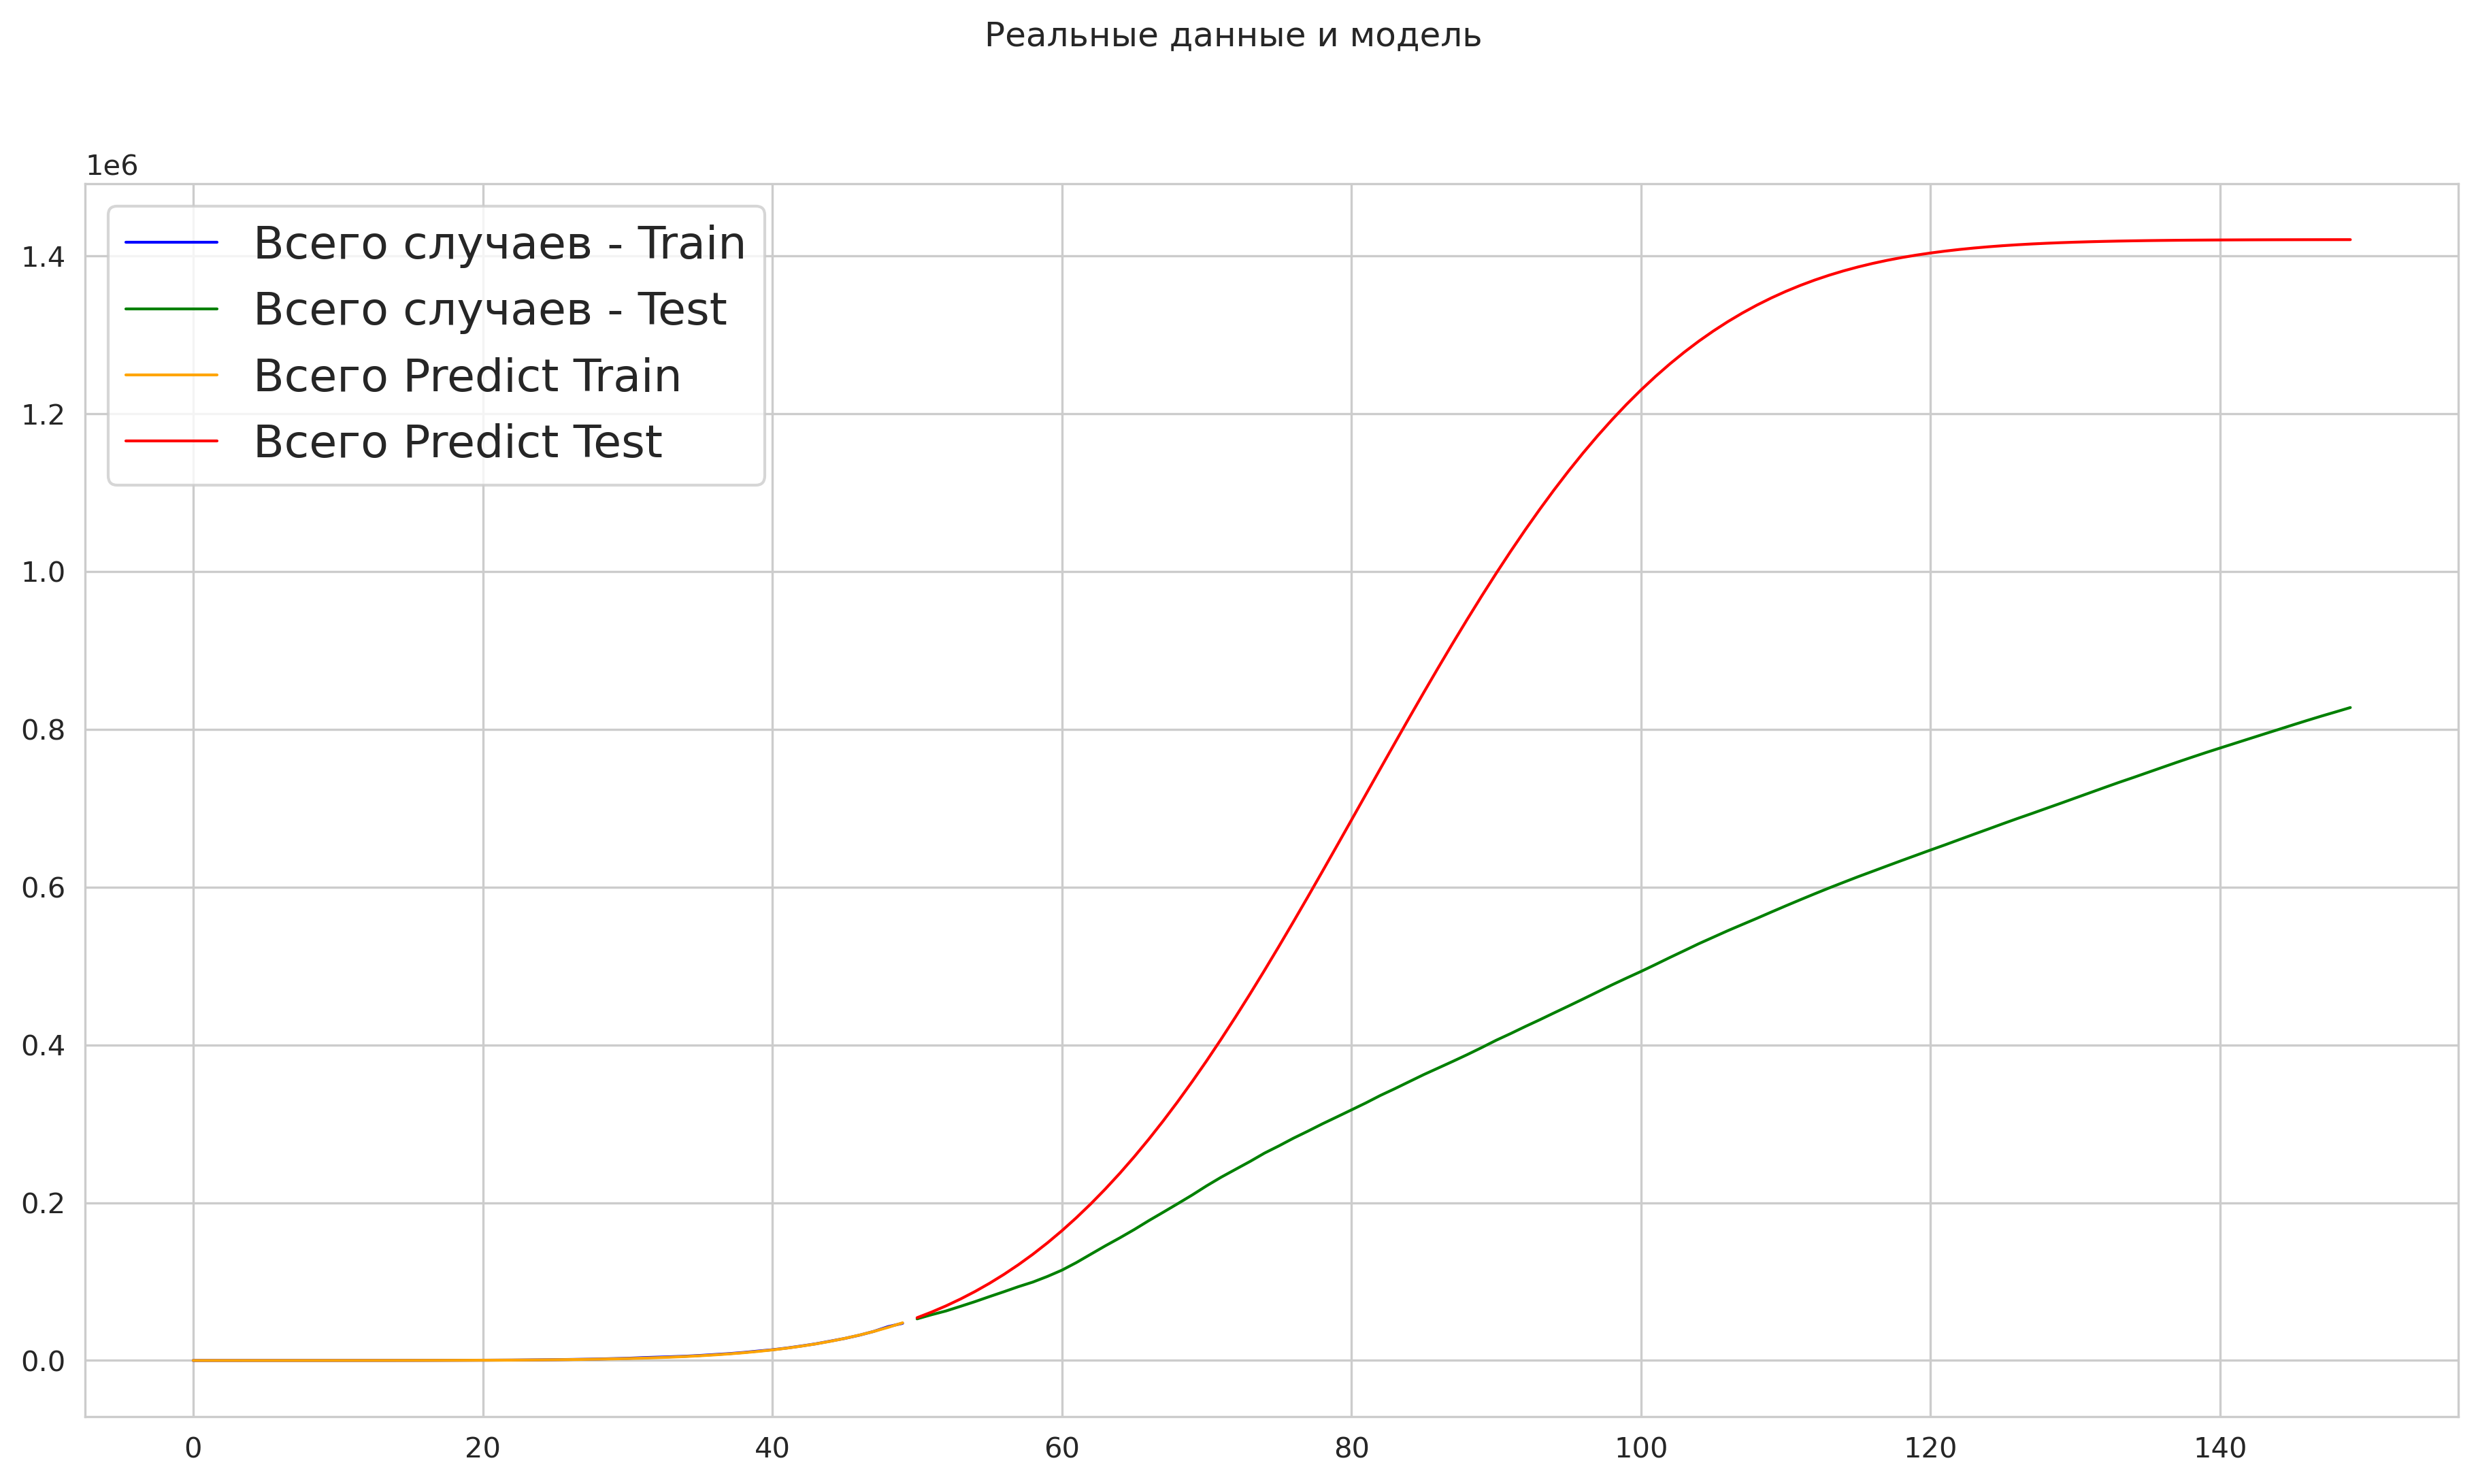

In [34]:
#Total number of cases
new_cases_train = np.exp(regr.predict(x_train))
new_cases_test = np.exp(regr.predict(x_test))
new_train_cumsum = np.cumsum(new_cases_train)
new_test_cumsum = np.cumsum(new_cases_test) + new_train_cumsum[-1]

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)

ax.plot(x_train[..., 0], train_df.total_cases, linewidth=1, label="Всего случаев - Train", color="blue")
ax.plot(x_test[..., 0], test_df.total_cases[:100], linewidth=1, label="Всего случаев - Test", color="green")
ax.plot(x_train[..., 0], new_train_cumsum, linewidth=1, label="Всего Predict Train", color="orange")
ax.plot(x_test[..., 0], new_test_cumsum, linewidth=1, label="Всего Predict Test", color="red")
ax.legend(loc="upper left", fontsize=legend_fontsize)

fig.suptitle('Реальные данные и модель')

plt.show()

# Task 4

In [35]:
new_data = data[['iso_code', 'date', 'total_cases_per_million', 'new_cases_per_million' ]].dropna()

In [36]:
new_data.iso_code.unique()

array(['AFG', 'ALB', 'DZA', 'AND', 'AGO', 'ATG', 'ARG', 'ARM', 'AUS',
       'AUT', 'AZE', 'BHS', 'BHR', 'BGD', 'BRB', 'BLR', 'BEL', 'BLZ',
       'BEN', 'BTN', 'BOL', 'BIH', 'BWA', 'BRA', 'BRN', 'BGR', 'BFA',
       'BDI', 'KHM', 'CMR', 'CAN', 'CPV', 'CAF', 'TCD', 'CHL', 'CHN',
       'COL', 'COM', 'COG', 'CRI', 'CIV', 'HRV', 'CUB', 'CYP', 'CZE',
       'COD', 'DNK', 'DJI', 'DMA', 'DOM', 'ECU', 'EGY', 'SLV', 'GNQ',
       'ERI', 'EST', 'SWZ', 'ETH', 'FJI', 'FIN', 'FRA', 'GAB', 'GMB',
       'GEO', 'DEU', 'GHA', 'GRC', 'GRD', 'GTM', 'GIN', 'GNB', 'GUY',
       'HTI', 'HND', 'HUN', 'ISL', 'IND', 'IDN', 'IRN', 'IRQ', 'IRL',
       'ISR', 'ITA', 'JAM', 'JPN', 'JOR', 'KAZ', 'KEN', 'OWID_KOS', 'KWT',
       'KGZ', 'LAO', 'LVA', 'LBN', 'LSO', 'LBR', 'LBY', 'LIE', 'LTU',
       'LUX', 'MDG', 'MWI', 'MYS', 'MDV', 'MLI', 'MLT', 'MHL', 'MRT',
       'MUS', 'MEX', 'FSM', 'MDA', 'MCO', 'MNG', 'MNE', 'MAR', 'MOZ',
       'MMR', 'NAM', 'NPL', 'NLD', 'NZL', 'NIC', 'NER', 'NGA', 'MKD',
       'NOR', '

In [37]:
def get_train_test(df, start_date, train_size=50, test_size=50):
    test_start_date = start_date + timedelta(train_size)
    test_end_date = test_start_date + timedelta(test_size)
    df['delta'] = df['date'] - start_date
    df['delta'] = df['delta'].apply(lambda x: x.days)
    train_df = df.query('date >= @start_date and date < @test_start_date')\
                            [['date', 'delta', 'total_cases_per_million', 'new_cases_per_million']]
    test_df = df.query('date >= @test_start_date and date < @test_end_date')\
                            [['date', 'delta', 'total_cases_per_million', 'new_cases_per_million']]
    min_array = sorted(train_df['new_cases_per_million'].unique())
    for i in range(len(min_array)):
        if min_array[i] > 0:
            minimum = min_array[i]
            break
    train_df['new_cases_per_million'] = train_df['new_cases_per_million'].apply(lambda x: x if x >= minimum else minimum)
    test_df['new_cases_per_million'] = test_df['new_cases_per_million'].apply(lambda x: x if x >= minimum else minimum)
    return train_df, test_df

In [38]:
def train_model(train_df, test_df):
    """Training sigmoids"""
    x_train = np.array(train_df.delta).reshape(-1, 1)
    y_train = np.log(train_df.new_cases_per_million)
    x_test = np.array(test_df.delta).reshape(-1, 1)
    y_test = np.log(test_df.new_cases_per_million)
    
    x_train = np.hstack((x_train, x_train ** 2))
    x_test = np.hstack((x_test, x_test ** 2))
    
    regr = LinearRegression()
    regr.fit(x_train, y_train)
    preds = regr.predict(x_test)
    
    return regr, map_error(y_test, preds)

In [39]:
all_countries = {}
for country in new_data.iso_code.unique():
    tmp_df = new_data.query('iso_code == @country')
    prev = 0
    for idx in tmp_df.index:
        if tmp_df.loc[idx]['new_cases_per_million'] > 0 and prev > 0:
            start_date = tmp_df.loc[idx]['date'] - timedelta(5) #two days before
#             print(country, start_date)
            train_df, test_df = get_train_test(tmp_df, start_date)
            model, error = train_model(train_df, test_df)
            result_dict = {}
            result_dict['start_date'] = start_date
            result_dict['model'] = model
            result_dict['error'] = error
            result_dict['train_df'] = train_df
            result_dict['test_df'] = test_df
            all_countries[country] = result_dict
            break
        else:
            prev = tmp_df.loc[idx]['new_cases_per_million']

In [40]:
points = []
errors = []
names = []
for country in all_countries.keys():
#     if all_countries[country]['error'] > 2.: #Some filtering
#         continue
    model = all_countries[country]['model']
#     if model.coef_[1] > 0:
#         continue
    point = list(model.coef_)
    point.append(model.intercept_)
    points.append(point)
    errors.append(all_countries[country]['error'])
    names.append(country)
points = np.array(points)

In [41]:
len(names)

185

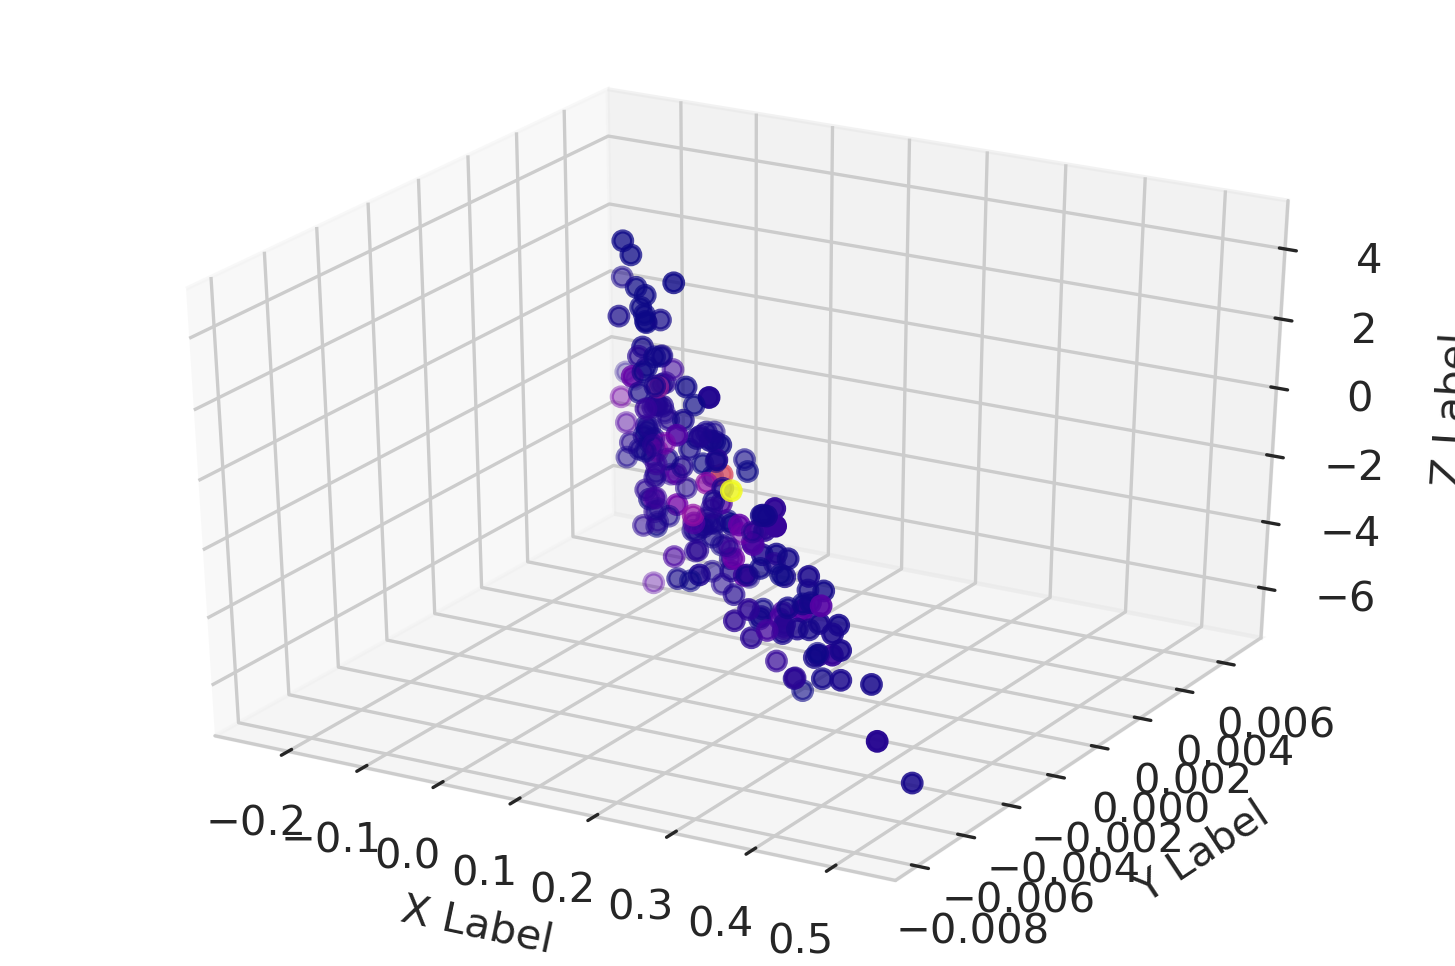

In [42]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(points[..., 0], points[..., 1], points[..., 2], c=errors, cmap='plasma')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()


In [43]:
from sklearn.cluster import DBSCAN, KMeans, SpectralClustering, AgglomerativeClustering

In [44]:
# clustering = DBSCAN(eps=0.2)
# clustering = KMeans(n_clusters=8)
# clustering = SpectralClustering(n_clusters=3)
clustering = AgglomerativeClustering(n_clusters=5)
clustering.fit(points)
clustering.labels_

array([0, 1, 0, 3, 0, 3, 0, 1, 2, 4, 2, 1, 1, 0, 1, 2, 4, 1, 4, 1, 4, 2,
       2, 0, 3, 2, 0, 2, 4, 4, 0, 1, 1, 4, 2, 2, 0, 1, 1, 2, 4, 4, 0, 2,
       4, 0, 4, 1, 3, 1, 0, 0, 2, 1, 2, 2, 1, 0, 1, 4, 4, 2, 2, 2, 4, 4,
       0, 3, 4, 2, 1, 1, 2, 4, 4, 1, 0, 0, 0, 0, 4, 4, 2, 1, 0, 2, 4, 4,
       1, 1, 2, 2, 2, 4, 1, 2, 2, 3, 2, 1, 2, 4, 4, 1, 4, 1, 2, 1, 0, 2,
       3, 2, 1, 0, 0, 0, 2, 0, 4, 4, 2, 0, 0, 1, 2, 2, 0, 2, 2, 4, 2, 0,
       0, 0, 4, 2, 0, 0, 2, 3, 1, 3, 3, 3, 4, 0, 2, 3, 4, 2, 2, 1, 0, 4,
       0, 4, 0, 2, 0, 1, 4, 2, 4, 4, 1, 0, 0, 1, 2, 1, 4, 0, 4, 0, 2, 0,
       0, 1, 0, 2, 0, 4, 4, 4, 4])

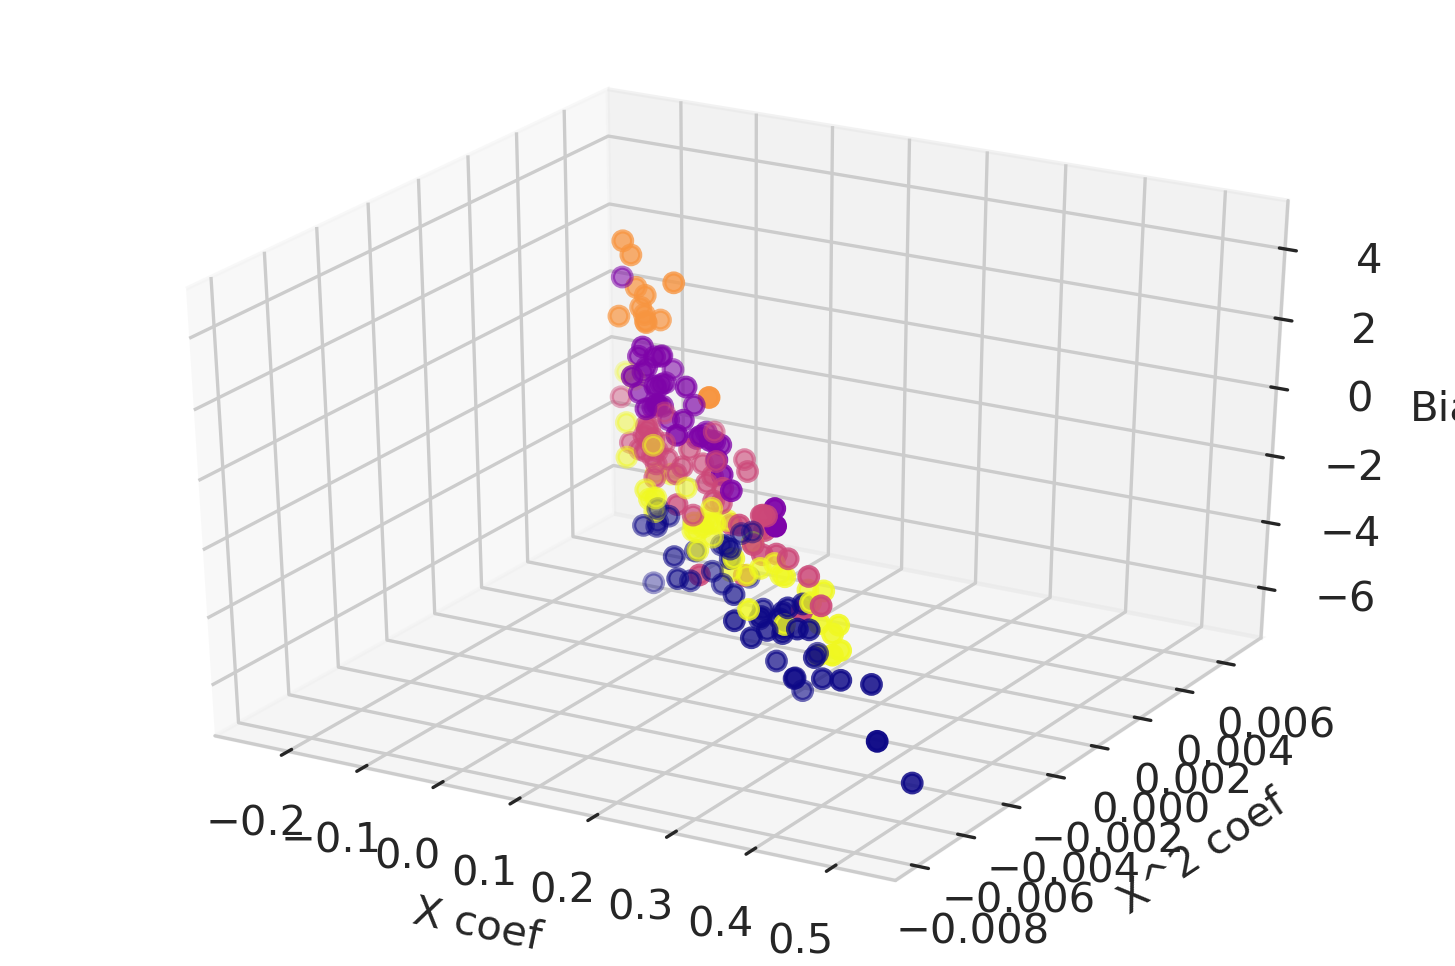

In [49]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(points[..., 0], points[..., 1], points[..., 2], c=clustering.labels_, cmap='plasma')

ax.set_xlabel('X coef')
ax.set_ylabel('X^2 coef')
ax.set_zlabel('Bias')

plt.show()

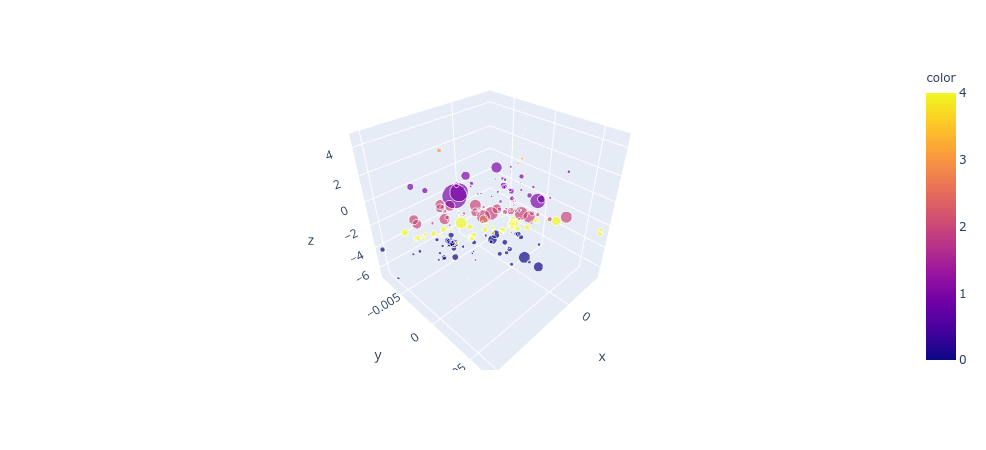

In [53]:
fig = plotly.express.scatter_3d(x=points[..., 0], y=points[..., 1], z=points[..., 2], color=clustering.labels_, size=errors)
fig.show()

Разделдить страны на кластеры у меня не получается. Все испробованные алгоритмы кластеризации гуппируют исключительно по величине свободного члена квадратичной функции. При этом обнаружена линейная зависимость коэффициентов при квадратичном и линейном членах. 

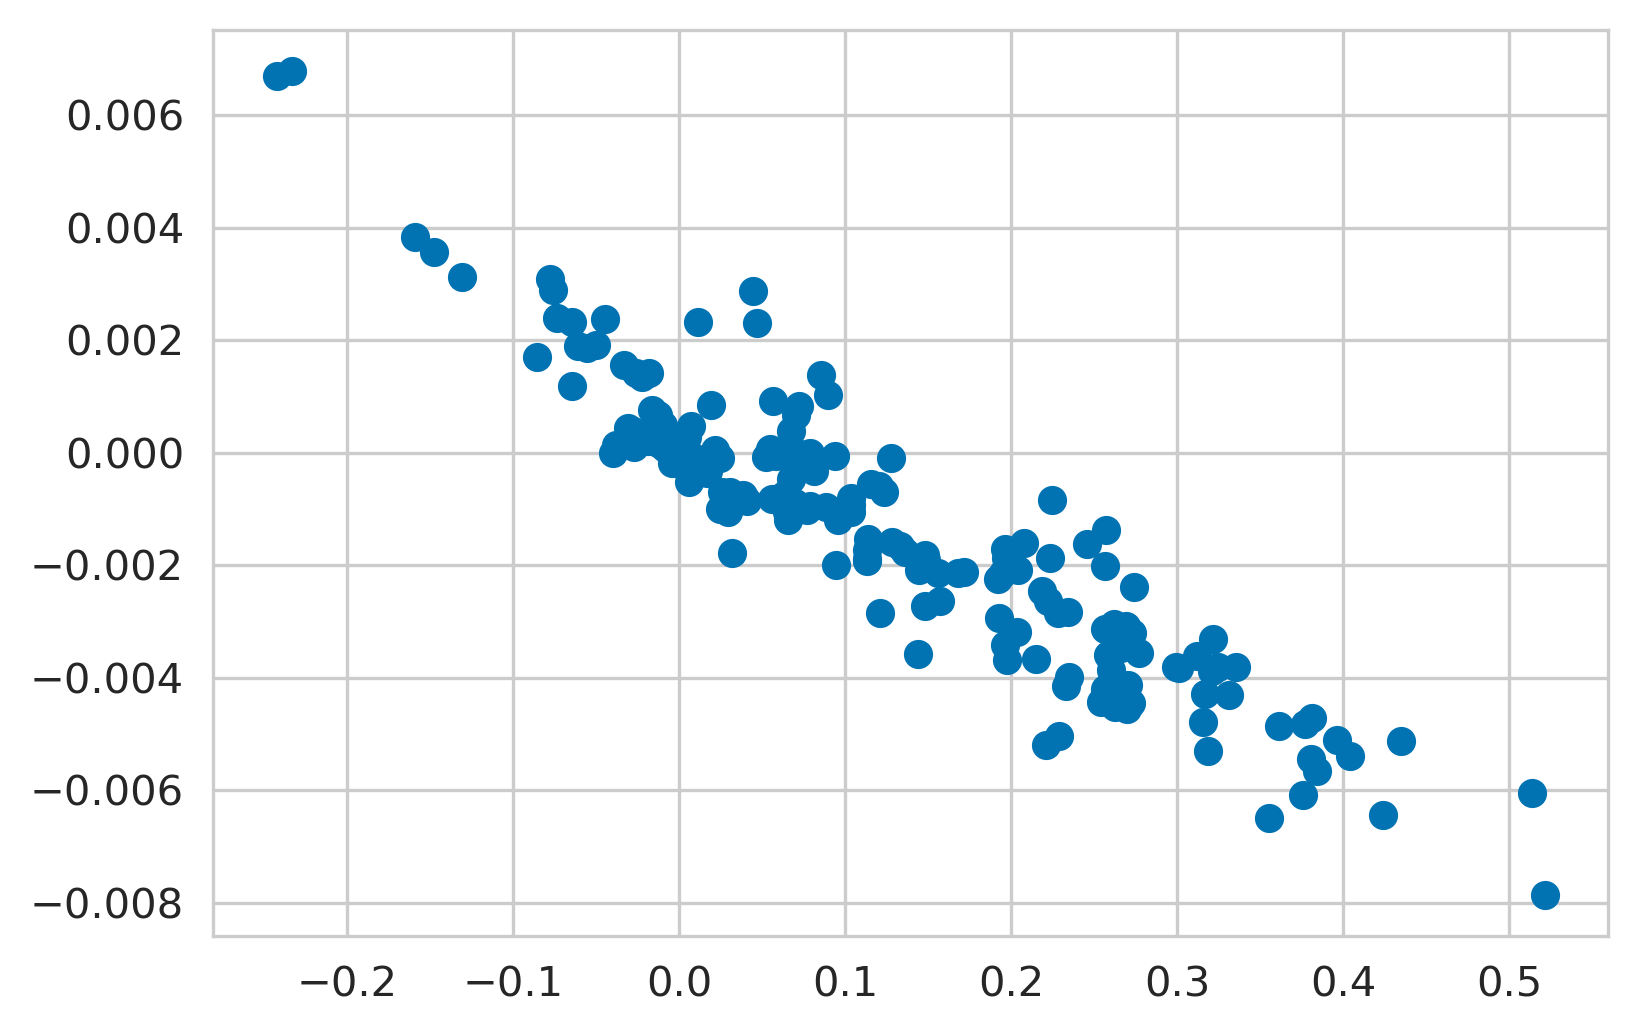

In [47]:
plt.scatter(points[..., 0], points[..., 1])
plt.show()

Я затрудняюсь объяснить этот феномен, но похоже он показывает, что развитие эпидемии в различных странах зависит, в основном, от одного параметра - количества новых заражений от каждого носителя.

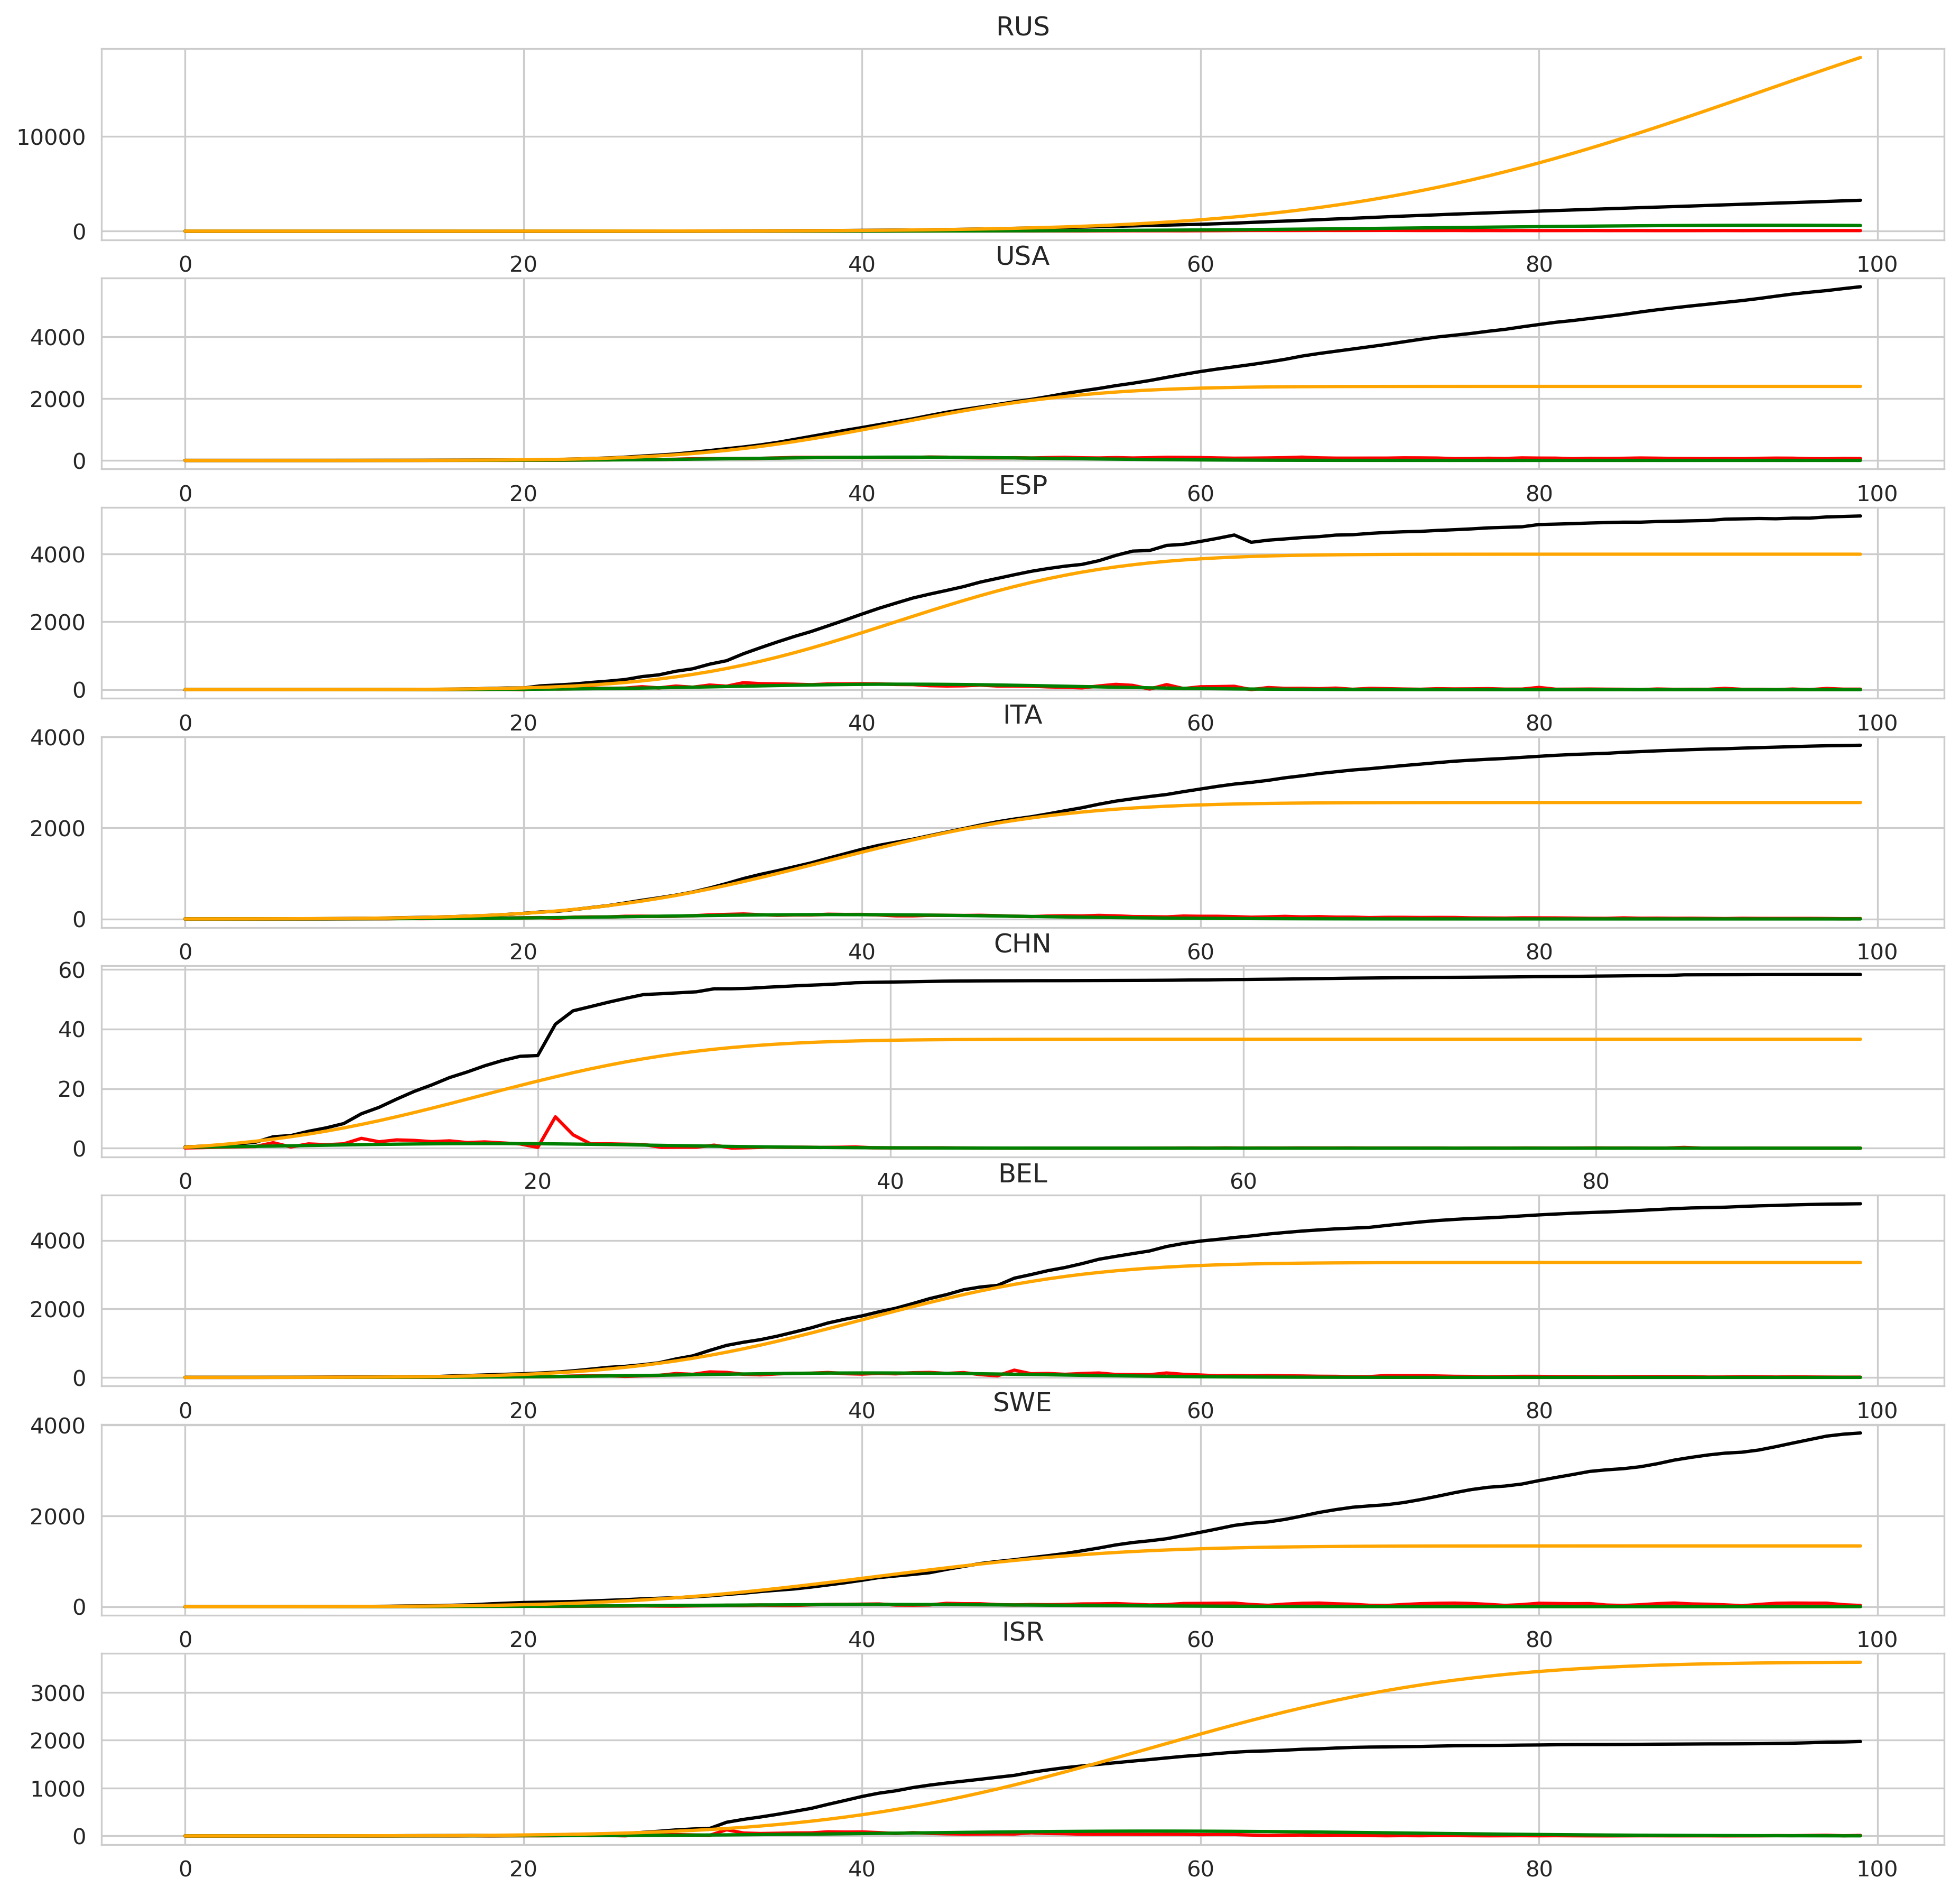

In [48]:
COUNTRIES = ['RUS', 'USA', 'ESP', 'ITA', 'CHN', 'BEL', 'SWE', 'ISR']

n = len(COUNTRIES)
fig = plt.figure(figsize=(15, 15))
for i, cur in enumerate(COUNTRIES):
    ax = fig.add_subplot(n, 1, i + 1)
    full_df = pd.concat([all_countries[cur]['train_df'], all_countries[cur]['test_df']])
    delta = np.array(full_df['delta']).reshape(-1, 1)
    delta = np.hstack((delta, delta ** 2))
    real_total = full_df['total_cases_per_million']
    real_daily = full_df['new_cases_per_million']
    cur_model = all_countries[cur]['model']
    preds = np.exp(cur_model.predict(delta))
    plt.plot(real_total.values, color='black')
    plt.plot(real_daily.values, color='red')
    plt.plot(preds, color='green')
    plt.plot(np.cumsum(preds), color='orange')
    ax.set_title(cur)
    ax.plot()

Выше представлены графики для некоторых стран. Похоже, что для большинства стран сигмоида дает оценку случаев заболевания снизу. Для части (Россия, Израиль) - сверху. Возможно, жэто связано с моментом введения жествких карантинных мер. Для части стран (Испания, Франция) автоматический подбор параметров привел к неверной форме кривой - коэффициент при $x^2$ оказался положительным и получили экспоненту.

Тем не менее, общее количество случаев (с учетом населения) оказывается примерно одинаковым для всех стран, кроме Китая, где крайне жесткие карантинные меры позволили быстро остановить распространение заболевания. Еще из интересного - пересечение реальной кривой и сигмоиды происходит в районе 50-го дня от начала эпидемии.

# Task 5

Главный вывод - модели достаточно сильно отличаются от реальности. Введение карантина - вопрос сложный. Так, в Китае был жесткий карантин и болезнь была подавлена в зародыше (60 случаев на миллион человек). В Швеции и США карантина практически не было и кривая заболевших сильно оличается от сигмоиды во второй половине интервала. В Испании и Италии жесткие карантинные меры после начального периода позволили приблизить кривые. Для России автоматически была выбрана не самая удачная точка - первое марта, график отличается от 3-го задания. 

В целом, я считаю что решение о введение карантинных мер нужно принимать с учетом ущерба от болезни, а не только глядя на число больных. Очень похоже, что в случае с COVID решение о введение карантина - правильное.